# Importation des modules 

In [529]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder #pour l'encodage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import classification_report
import sklearn.metrics as me
from sklearn.metrics import precision_score,recall_score,accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

# Fonctions 

In [2]:
# fonction qui donne le taux de remplissage et nous dit les colonnes vides
# nous renseigne aussi le taux de remplissage
# le taux de valeurs manquantes
def TraceValeurMissing(base):

    col_vides = []
    for col in base.columns:
        if base[col].isnull().all():
          # all Renvoie True si au moins
          # un élément de iterable est vrai. False est renvoyé dans
          # le cas où iterable est vide
            col_vides.append(col)
    print('les colonnes vides sont:\n\n')
    display(col_vides)  # affiche tete de table
    t = pd.DataFrame(index=['number of missing values',
                     'number of values', 'fill_rate'], columns=base.columns)
    for col in base.columns:
        nb_nan = base[col].isnull().sum()
        t.loc['number of missing values', col] = nb_nan
        t.loc['number of values', col] = base.shape[0]-nb_nan
        t.loc['fill_rate', col] = (base.shape[0]-nb_nan)/(base.shape[0]*1.0)
        # taux de remplissage
    display(t)  # pd.set
    dico = {'columns': base.columns, 'fill_rate': (
        t.loc['fill_rate', base.columns]*100), 'missing_values': (100-t.loc['fill_rate', base.columns]*100)}
    tr = pd.DataFrame(dico)
    tr = tr.sort_values(by='fill_rate', ascending=False)  # trier le tableau
    barWidth = 0.85  # largeur des barres
    plt.figure(figsize=(8, 10))
    plt.gca().invert_yaxis()  # pour creer des axes polaires valeur d'une graduation
    # taille des graduations
# plt.barh creation dune barre horizontale
    plt.barh(tr['columns'], tr['fill_rate'], color='#a3acff')
    plt.barh(tr['columns'], tr['missing_values'],
             left=tr['fill_rate'], color='#b5ffb9')
    plt.title('Taux de remplissage', fontsize=30)
    plt.yticks(fontsize=10)
    plt.ylabel('columns', fontdict={'fontsize': 20})
    plt.xlabel('fill rate(%)', fontdict={'fontsize': 20})

    plt.axvline(x=80, color='b')
    plt.text(82, -1, '>80%', color='b')
    plt.axvline(x=20, color='r')
    plt.text(12, -1, '<20%', color='r')
    plt.axvline(x=50, color='g')
    plt.text(50, -1, '>50%', color='b')
    plt.grid(True)

In [3]:
def Histo(colonne,base,bines):
  sns.displot(x=colonne,data=base, kde=False, bins=bines,color="darkblue")
  plt.grid()

In [51]:
def Moustache (Base, colonne):
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=Base, x=colonne)
    plt.title('Dispersion de la variable {}'.format(colonne))
    #sns.displot(data=Base, x=colonne, bins=20, kde=True)
    #plt.title('Dispersion de la variable {}'.format(colonne))

In [142]:
#fonction qui calcule les outliers ou l'utilisateur choisit son 
#ecart 1.5,3 ou 5
#il nous retourne les index les valeurs 
#en entree il nous donne le nom de la colonne 
def CalculOutlier(v):
  ecart=input('Donnez votre écart = ')
  ecart=float(ecart) #conversion de ecart en float
  #cette fonction nous donne les index et valeurs des valeurs aberrantes
  #le nom de la colonne
  Q1=v.quantile(0.25)
  Q3=v.quantile(0.75)
  EIQ=Q3-Q1
  LI=Q1-ecart*EIQ
  LS=Q3+ecart*EIQ
  i=list(v.index[(v < LI)|(v > LS)])
  val=list(v[i])
  print('Voila votre résultat pour un ecart interquartile de {}'.format(ecart))
  return i, val
  

In [525]:
def conf_mat_transform(y_test,y_pred) :
    conf_mat = me.confusion_matrix(y_test,y_pred)
    
    corresp = np.argmax(conf_mat,axis=0) 
    #vu quon a un numero de colonne de
    #la valeur max les meme pour deux lignes on le fait manuellement
    #on na pas des accuracy proche de 1 on pouvait utiliser le argmax
    #corresp = [0, 3, 6, 4, 2, 1, 5]
    #print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_test, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

# Téléchargement table

In [642]:
data=pd.read_csv('Satisfaction.csv')

In [3]:
data.head(2)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0


In [5]:
data.shape
#nous avons une table avec 129880 lignes et 23 colonnes 

(129880, 23)

In [6]:
data.tail(2)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
129878,dissatisfied,Male,disloyal Customer,66,Personal Travel,Eco,2450,3,2,3,...,2,3,3,2,3,2,1,2,193,205.0
129879,dissatisfied,Female,disloyal Customer,38,Personal Travel,Eco,4307,3,4,3,...,3,4,5,5,5,3,3,3,185,186.0


# Etudes valeurs manquantes 

les colonnes vides sont:




[]

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
number of missing values,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,393
number of values,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,...,129880,129880,129880,129880,129880,129880,129880,129880,129880,129487
fill_rate,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.996974


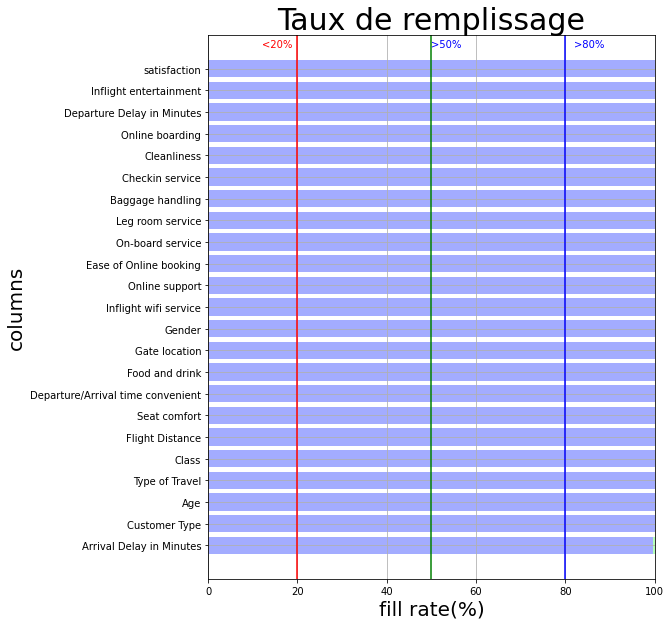

In [6]:
TraceValeurMissing(data)

In [8]:
data.isna().sum()
#une colonne a des valeurs manquantes 

satisfaction                           0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

# Etudes des types 

In [9]:
data.dtypes.value_counts()
#nous avons 17 int et 1 float  
#5 catégorielles

int64      17
object      5
float64     1
dtype: int64

Text(0.5, 1.0, 'Les différentes variables')

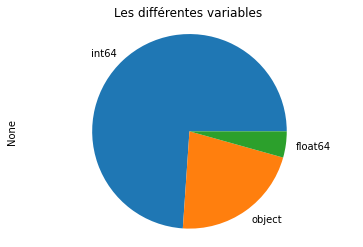

In [17]:
plt.figure()
data.dtypes.value_counts(normalize=True).plot(kind='pie');
plt.axis('equal')
plt.title('Les différentes variables')

In [18]:
data.select_dtypes('object').columns

Index(['satisfaction', 'Gender', 'Customer Type', 'Type of Travel', 'Class'], dtype='object')

# Etudes des doublons

In [19]:
data.duplicated().value_counts()
#Nous voyons qu'on a pas de doublons pour notre table

False    129880
dtype: int64

In [20]:
data.head(3)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0


# Analyse exploratoire catégorielle

In [21]:
# number of unique classes in each object column
data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

satisfaction      2
Gender            2
Customer Type     2
Type of Travel    2
Class             3
dtype: int64

In [22]:
data.select_dtypes('object').columns

Index(['satisfaction', 'Gender', 'Customer Type', 'Type of Travel', 'Class'], dtype='object')

In [23]:
data['satisfaction'].shape[0]

129880

In [24]:
(data['satisfaction'].value_counts())/data['satisfaction'].shape[0]

satisfied       0.547328
dissatisfied    0.452672
Name: satisfaction, dtype: float64

Text(0.5, 1.0, 'Nous avons 55% de clients satisfaits pour 45% de non satisfaits')

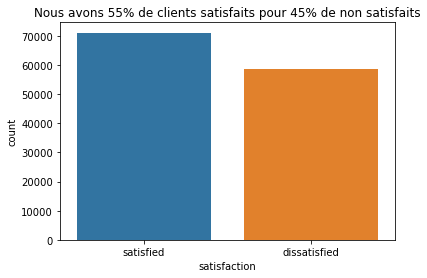

In [25]:
plt.figure()
sns.countplot(x=data['satisfaction'])
plt.title('Nous avons 55% de clients satisfaits pour 45% de non satisfaits')

Text(0.5, 1.0, 'Nous avons 55% de clients satisfaits pour 45% de non satisfaits')

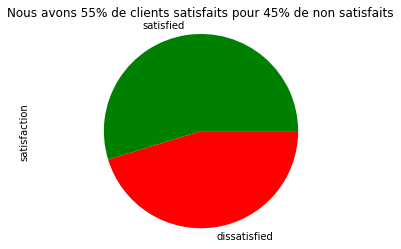

In [628]:
plt.figure()
data['satisfaction'].value_counts(normalize=True).plot(kind='pie',colors=['green','red']);
plt.axis('equal')
plt.title('Nous avons 55% de clients satisfaits pour 45% de non satisfaits')

In [644]:
#le tableau des variables catégorielles
cat_col=data.select_dtypes('object').drop(columns='satisfaction')
#le nom des variables catégorielles
var_cat=cat_col.select_dtypes('object').columns

In [645]:
cat_col.head()

,Gender,Customer Type,Type of Travel,Class
0,Female,Loyal Customer,Personal Travel,Eco
1,Male,Loyal Customer,Personal Travel,Business
2,Female,Loyal Customer,Personal Travel,Eco
3,Female,Loyal Customer,Personal Travel,Eco
4,Female,Loyal Customer,Personal Travel,Eco


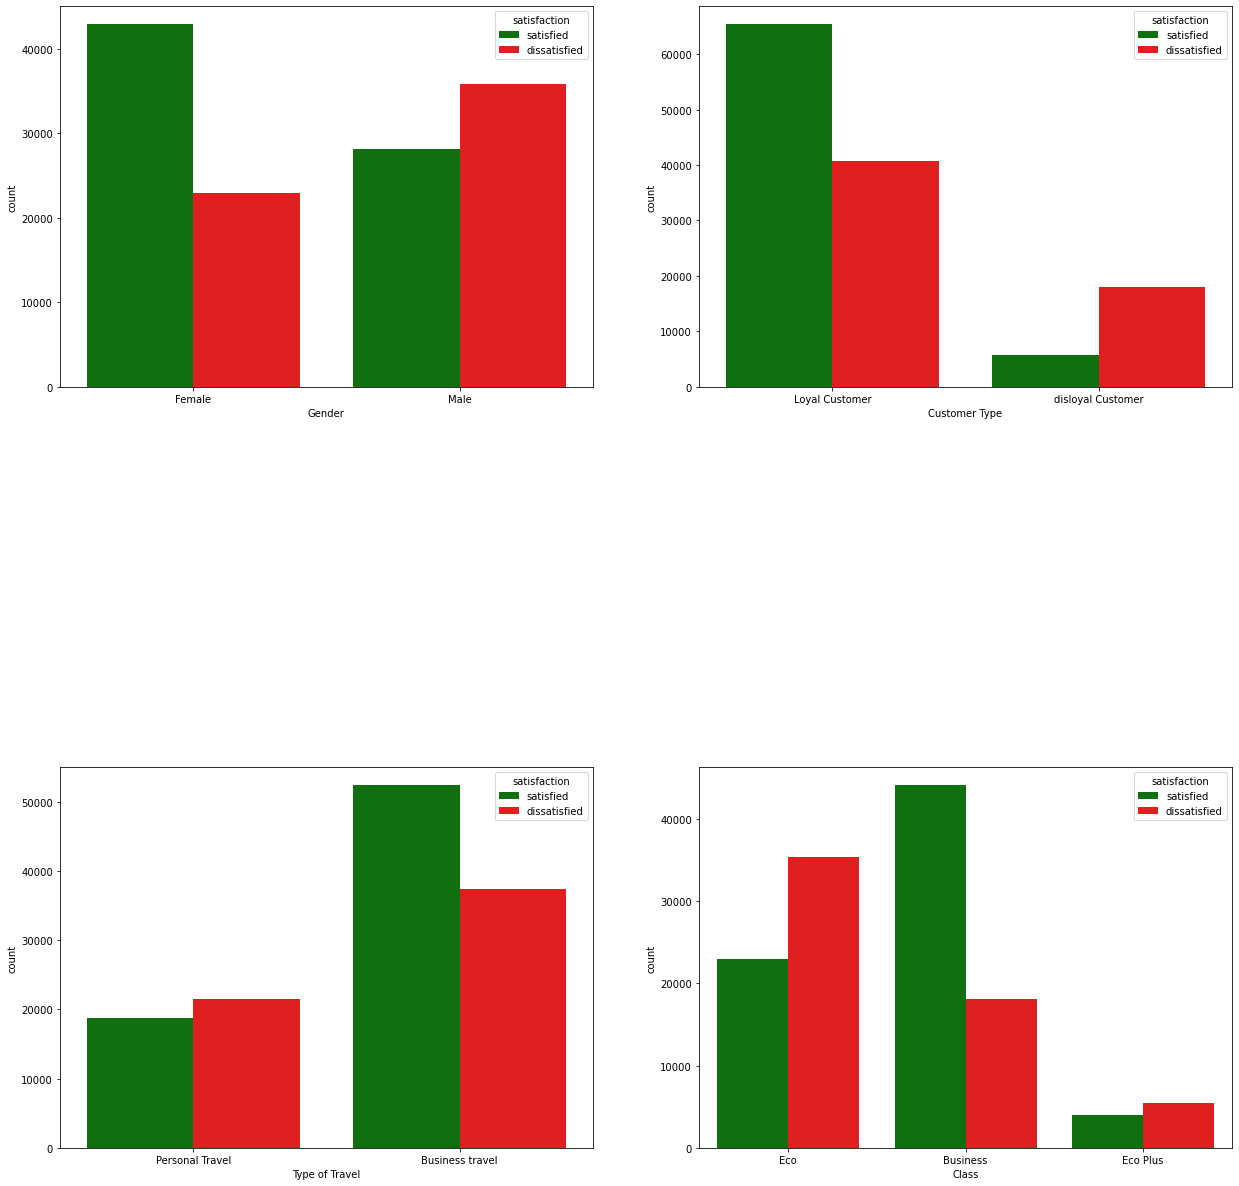

In [660]:

fig,axes=plt.subplots(2,2,figsize=(21,21))
for idx, cat_col in enumerate(var_cat):
  row,col=idx//2,idx%2
  sns.countplot(x=cat_col,data=data,hue=data['satisfaction'],ax=axes[row,col],palette=dict(satisfied = 'g', dissatisfied = 'r'))

plt.subplots_adjust(hspace=1)

In [60]:
data.select_dtypes('object').isna().sum()
#pas de valeurs manquantes 

satisfaction      0
Gender            0
Customer Type     0
Type of Travel    0
Class             0
dtype: int64

# Analyse exploratoire numérique

In [57]:
#le tableau des variables numériques
var_num=data.select_dtypes(['int64','float'])
#le nom des variables numériques 
num_name=data.select_dtypes(['int64','float']).columns

In [58]:
var_num.describe()

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,39.427957,1981.409055,2.838597,2.990645,2.851994,2.990422,3.249130,3.383477,3.519703,3.472105,3.465075,3.485902,3.695673,3.340807,3.705759,3.352587,14.713713,15.091129
std,15.119360,1027.115606,1.392983,1.527224,1.443729,1.305970,1.318818,1.346059,1.306511,1.305560,1.270836,1.292226,1.156483,1.260582,1.151774,1.298715,38.071126,38.465650
min,7.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1359.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,1925.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000
75%,51.000000,2544.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,6951.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [59]:
var_num.isna().sum()

Age                                    0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

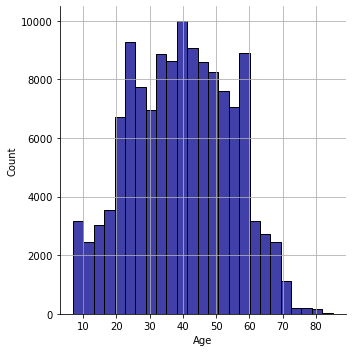

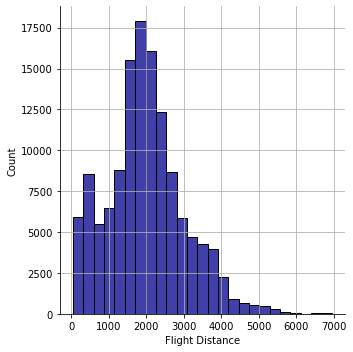

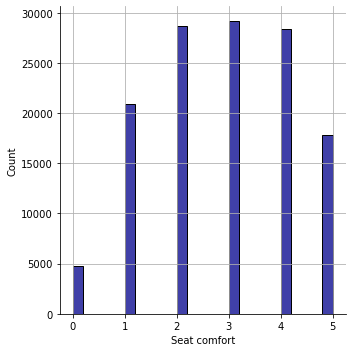

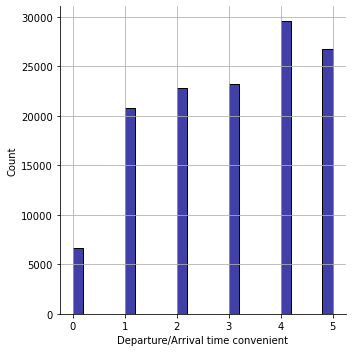

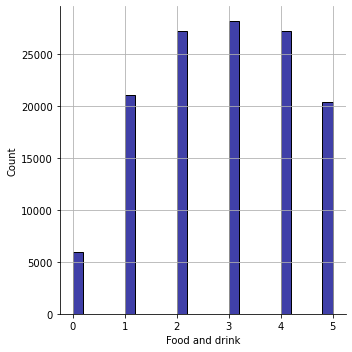

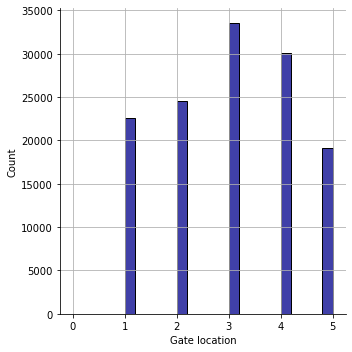

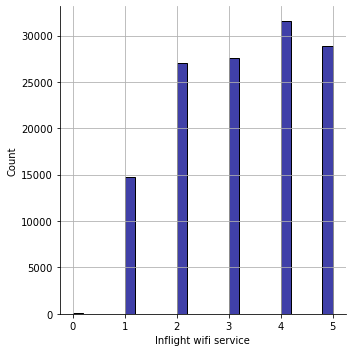

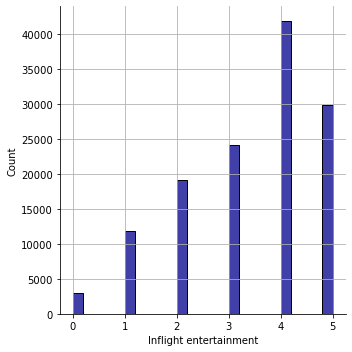

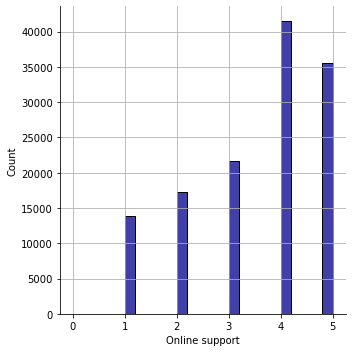

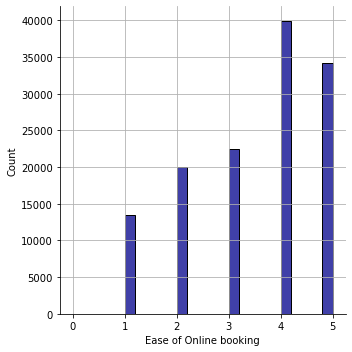

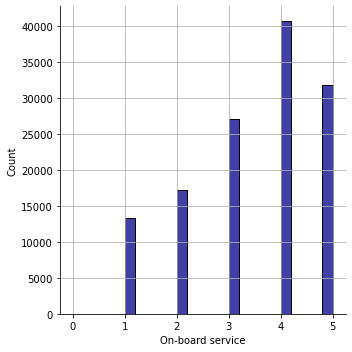

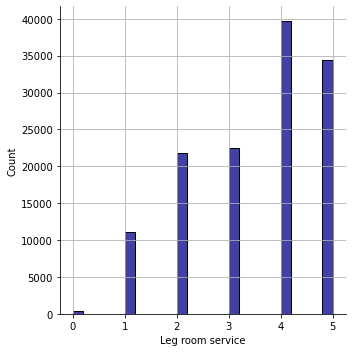

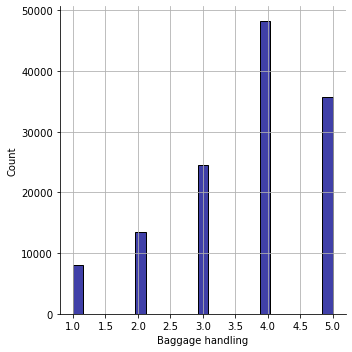

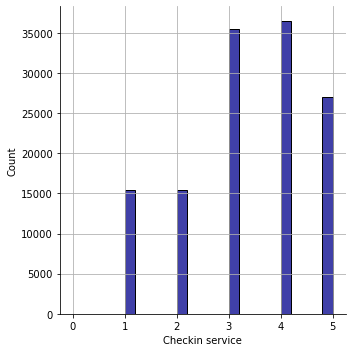

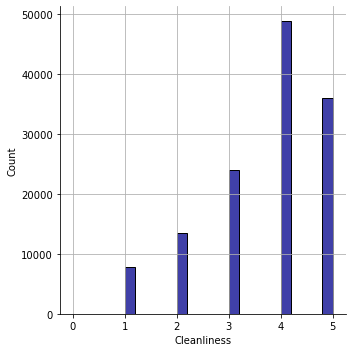

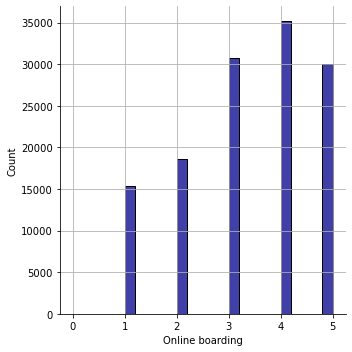

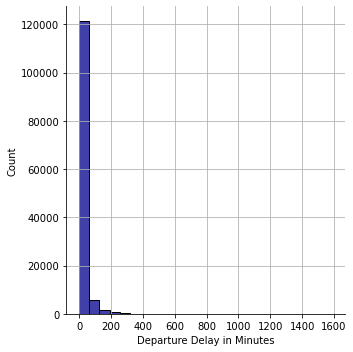

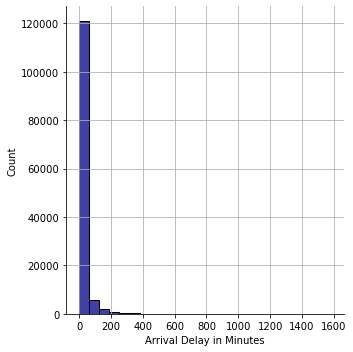

In [60]:
for cat in num_name:
    #plt.figure()
    Histo(cat,var_num,25)
    #plt.title(cat)

<AxesSubplot:>

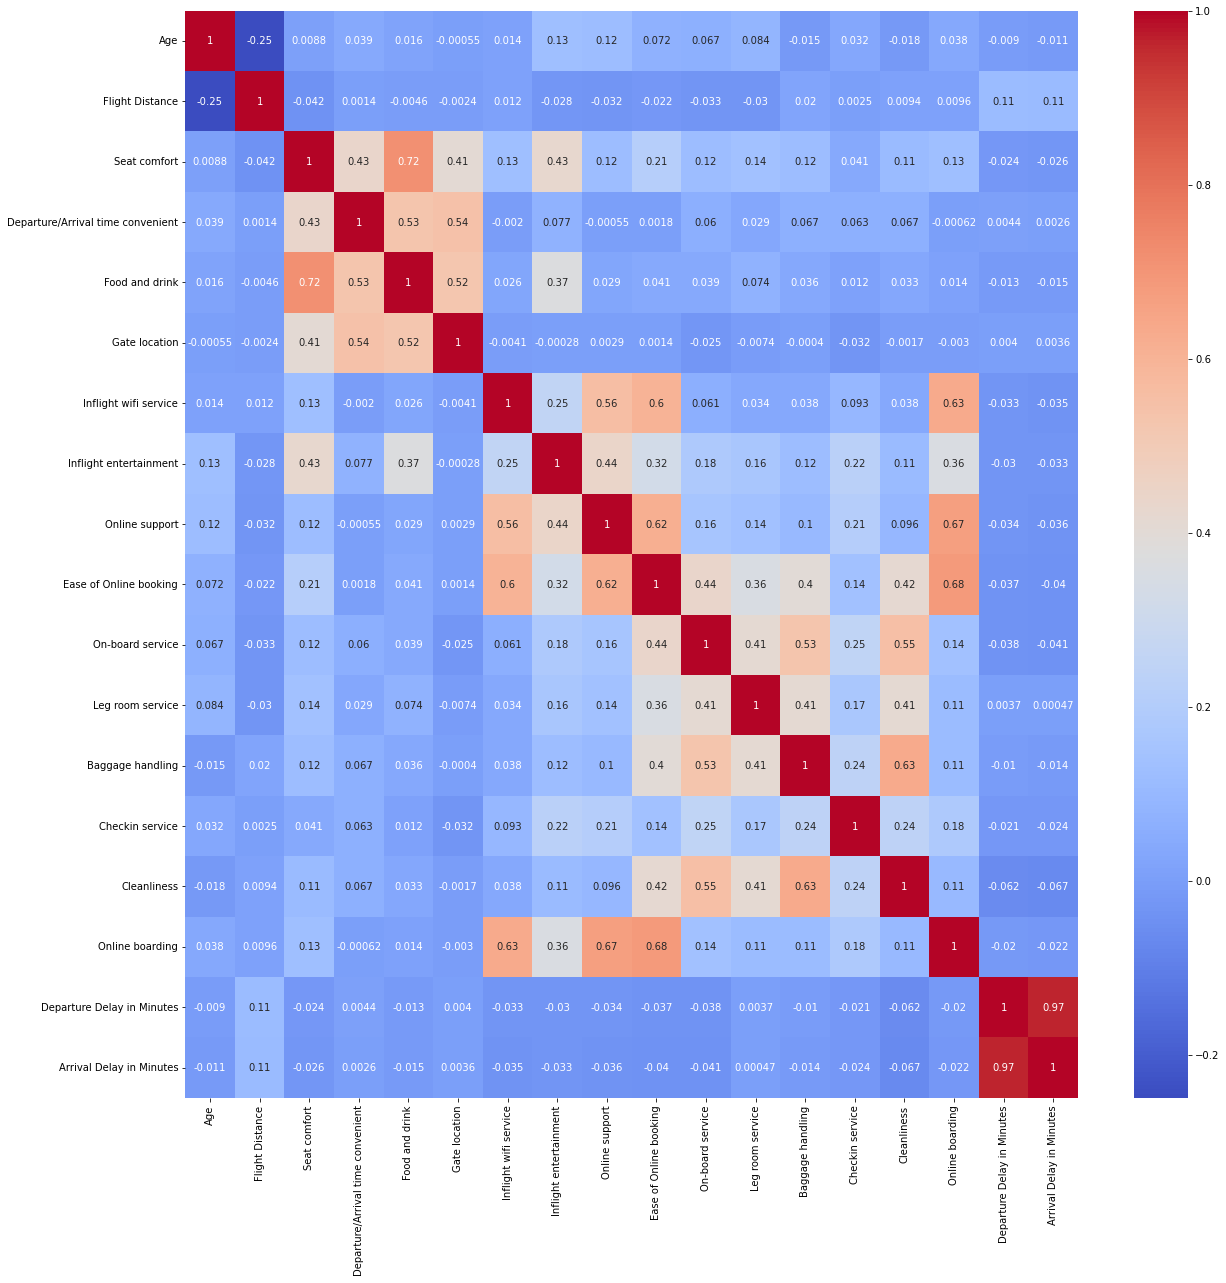

In [32]:
ext_data_corrs = var_num.corr()
fig,ax=plt.subplots(figsize=(20,20))
sns.heatmap(ext_data_corrs,annot=True,ax=ax,cmap='coolwarm')

In [61]:
var_num.columns

Index(['Age', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

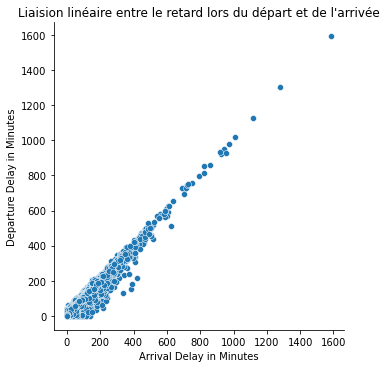

In [62]:
plt.figure();
sns.relplot(x='Arrival Delay in Minutes',y='Departure Delay in Minutes',data=var_num);
plt.title("Liaision linéaire entre le retard lors du départ et de l'arrivée");

## suppresion de la variable manquante 

In [37]:
var_num.isna().sum()

Age                                    0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

In [38]:
var_num.shape

(129880, 18)

In [65]:
#suppression de la variable Arrival Delay in Minutes
var_num=var_num.drop(columns='Arrival Delay in Minutes')

In [74]:
#le nom des variables numériques 
name=var_num.columns

In [75]:
var_num.shape

(129880, 17)

les colonnes vides sont:




[]

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes
number of missing values,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
number of values,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880
fill_rate,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


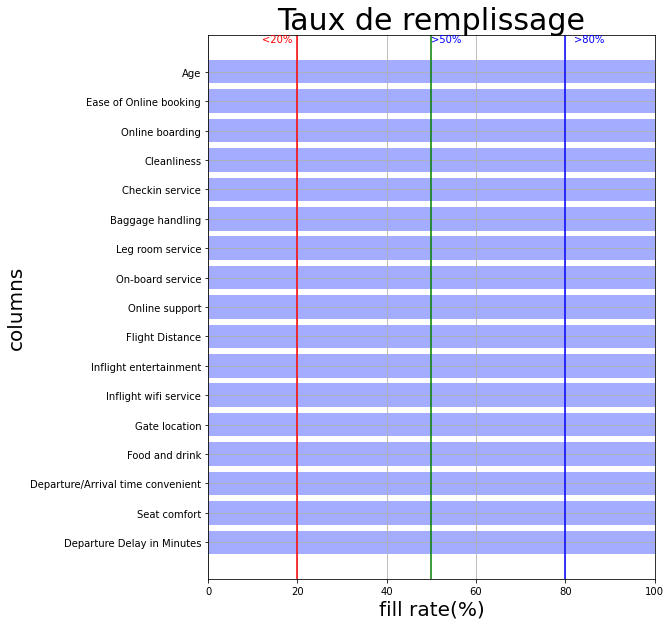

In [73]:
TraceValeurMissing(var_num)

les colonnes vides sont:




[]

,Gender,Customer Type,Type of Travel,Class
number of missing values,0,0,0,0
number of values,129880,129880,129880,129880
fill_rate,1.0,1.0,1.0,1.0


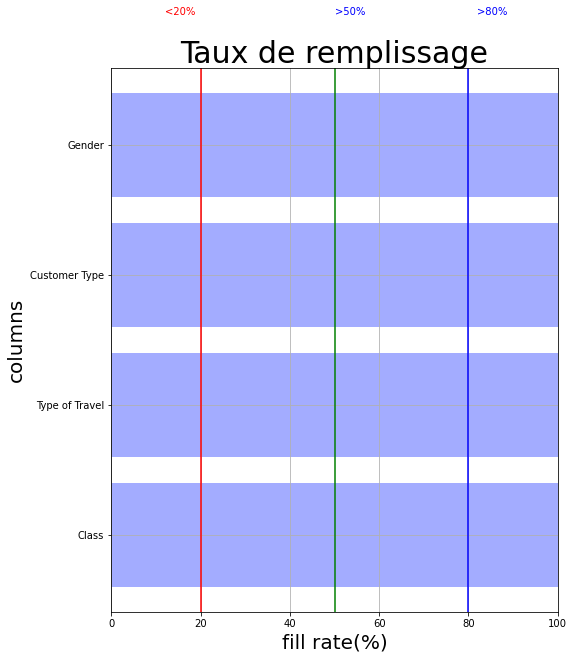

In [50]:
TraceValeurMissing(cat_col)

# Etudes des outliers 

In [69]:
var_num.head()

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes
0,65,265,0,0,0,2,2,4,2,3,3,0,3,5,3,2,0
1,47,2464,0,0,0,3,0,2,2,3,4,4,4,2,3,2,310
2,15,2138,0,0,0,3,2,0,2,2,3,3,4,4,4,2,0
3,60,623,0,0,0,3,3,4,3,1,1,0,1,4,1,3,0
4,70,354,0,0,0,3,4,3,4,2,2,0,2,4,2,5,0


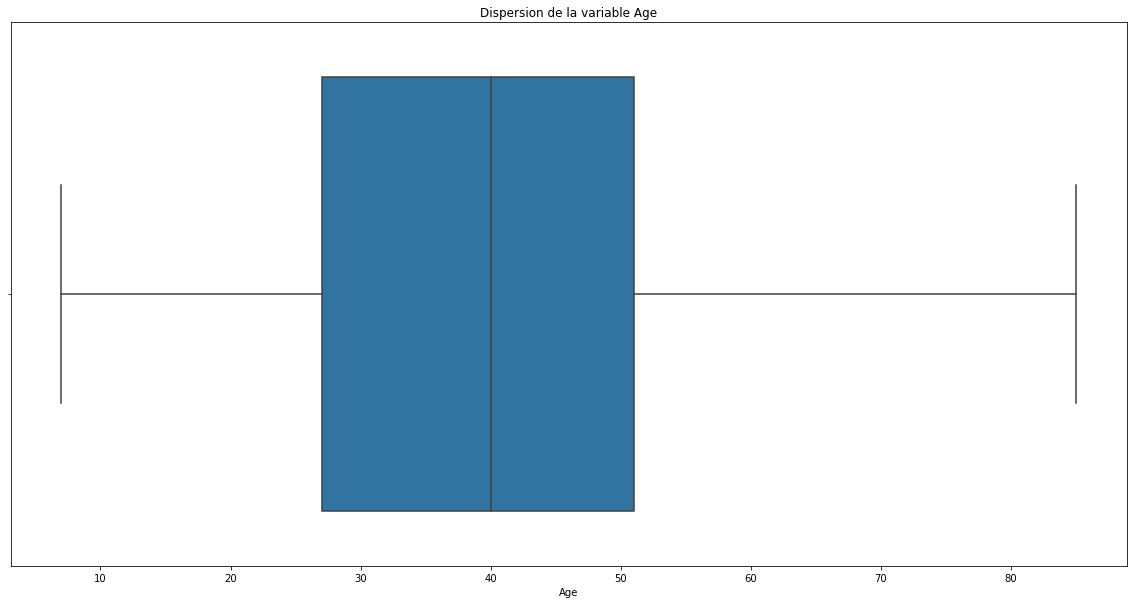

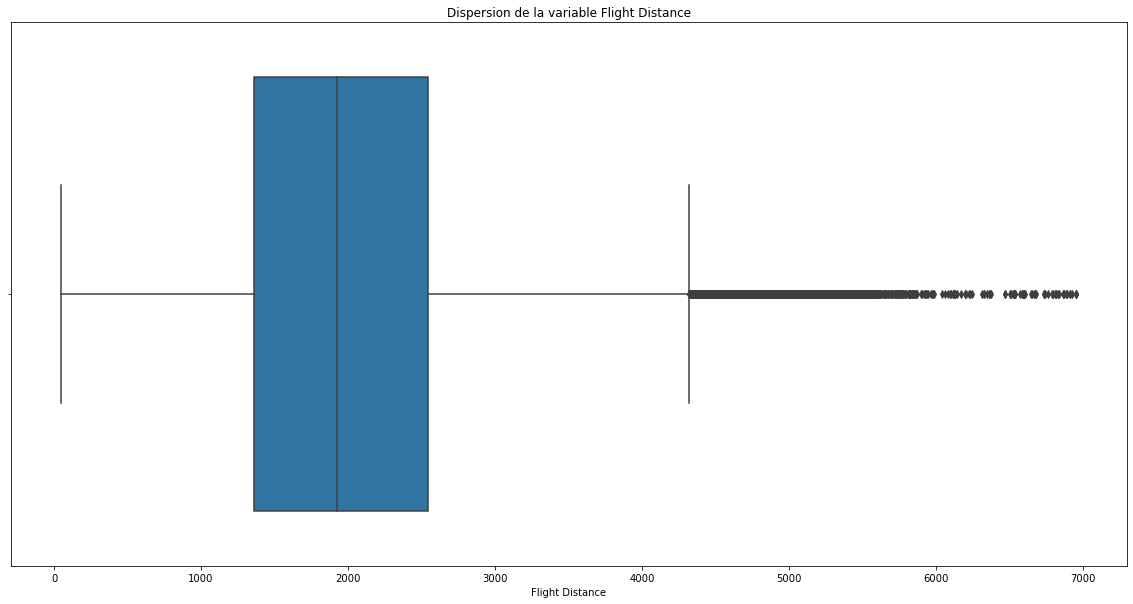

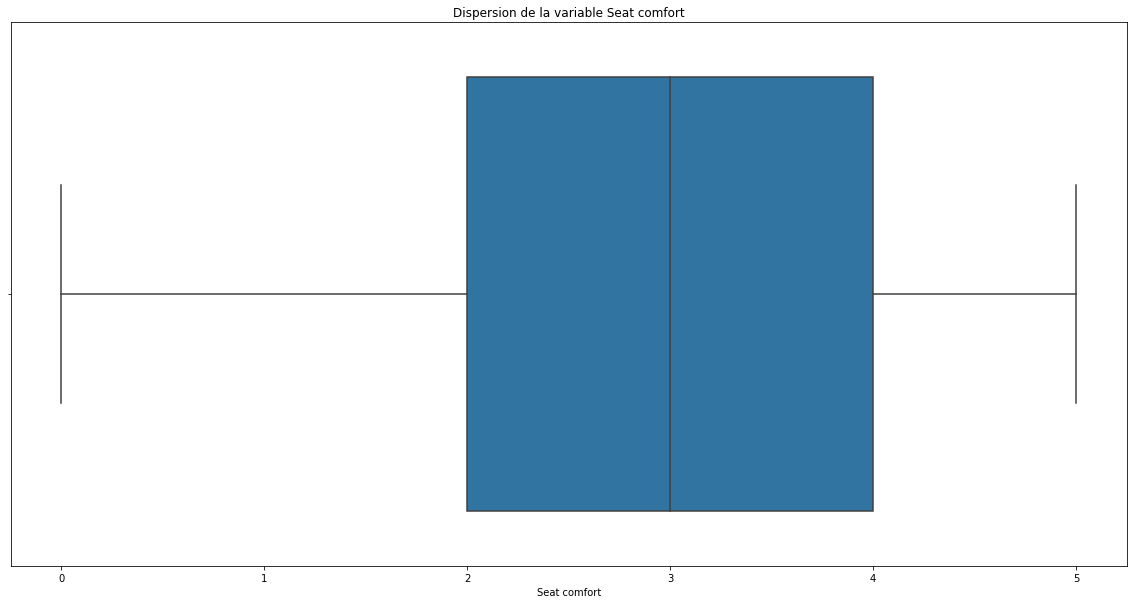

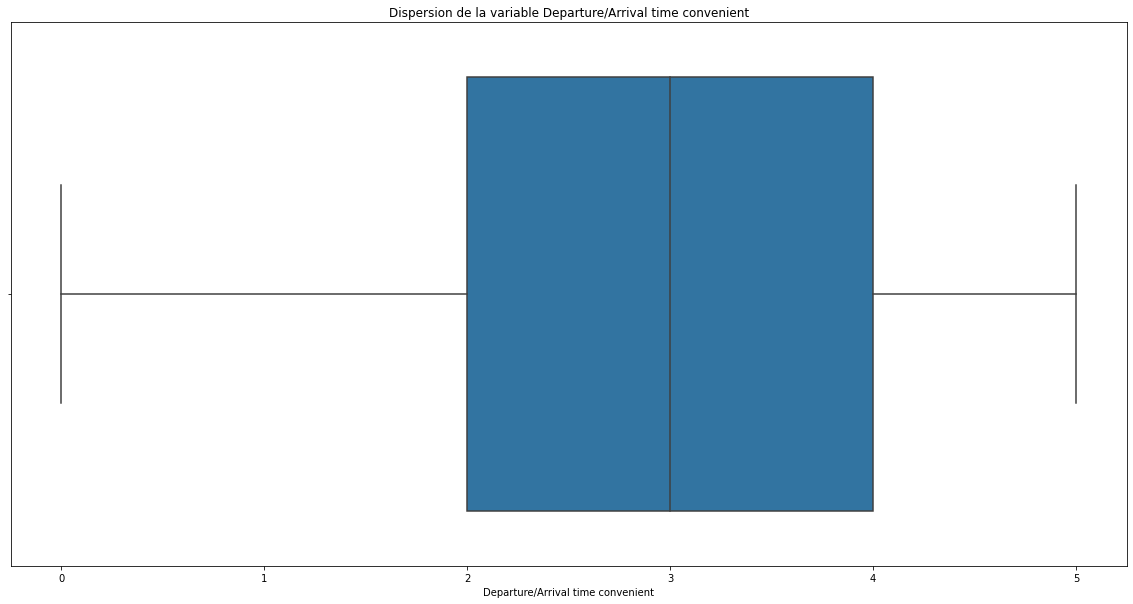

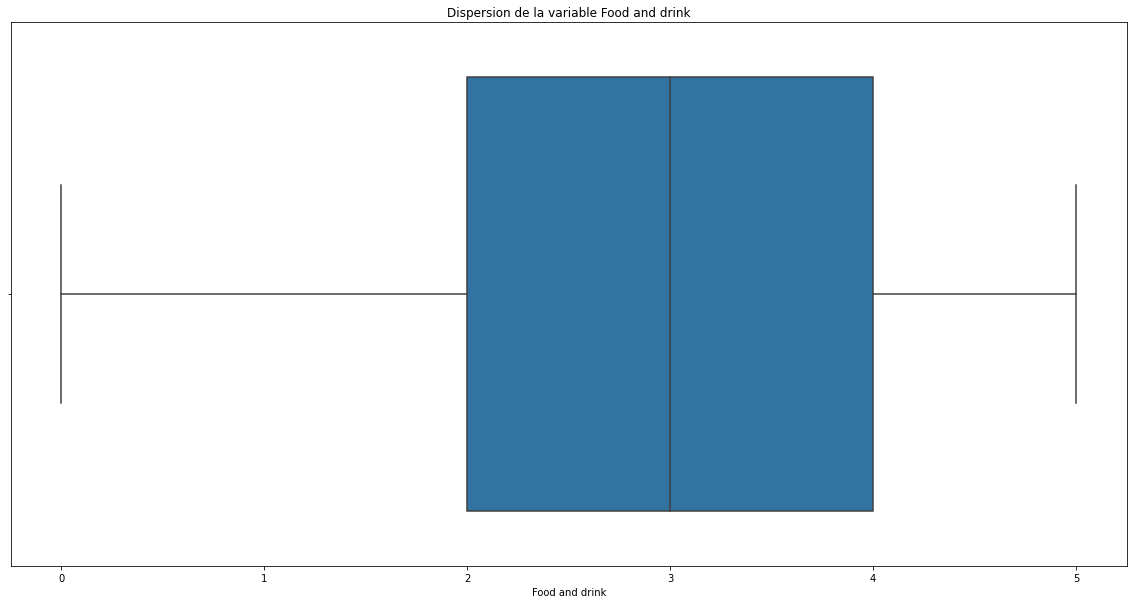

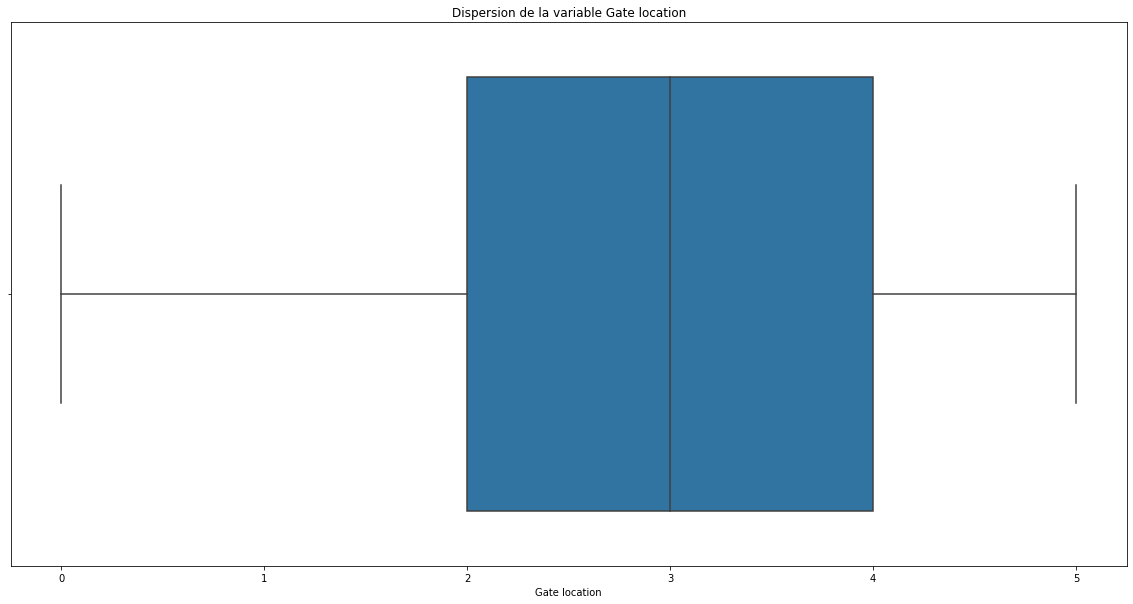

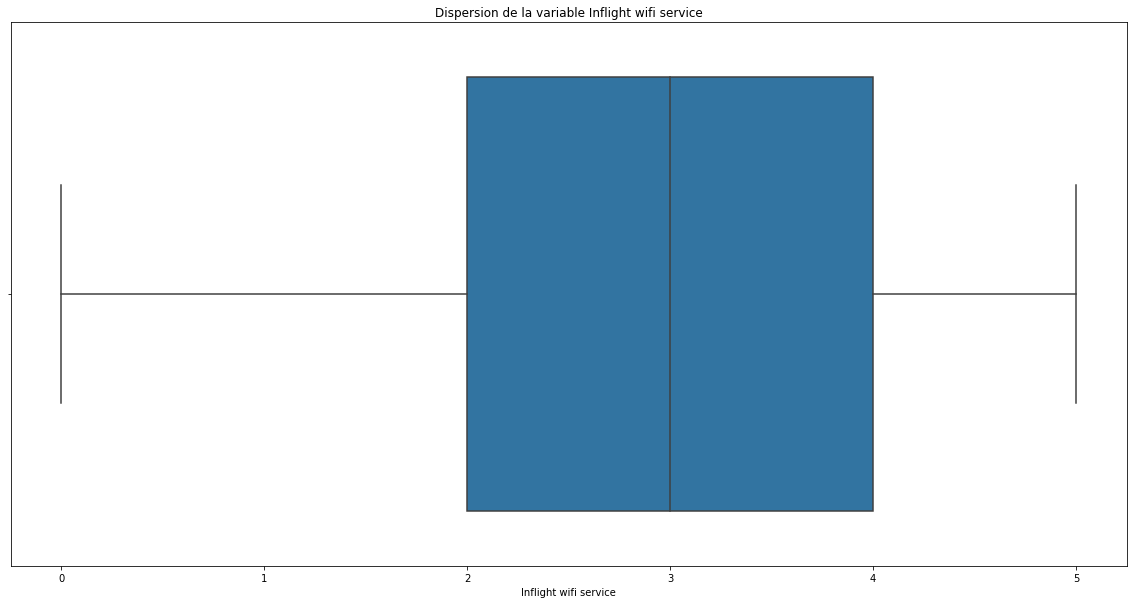

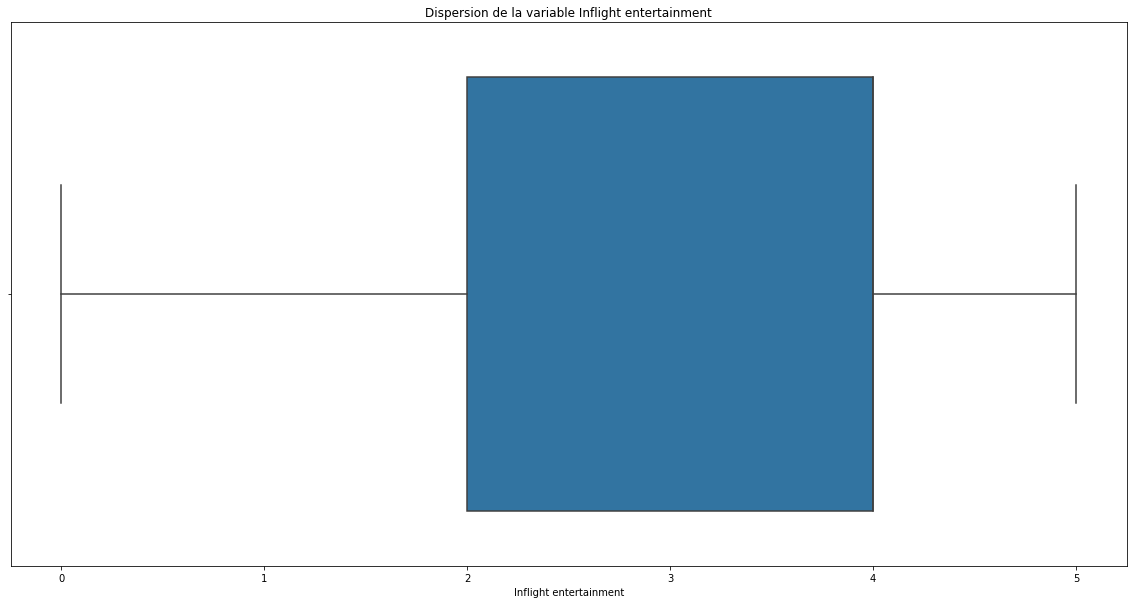

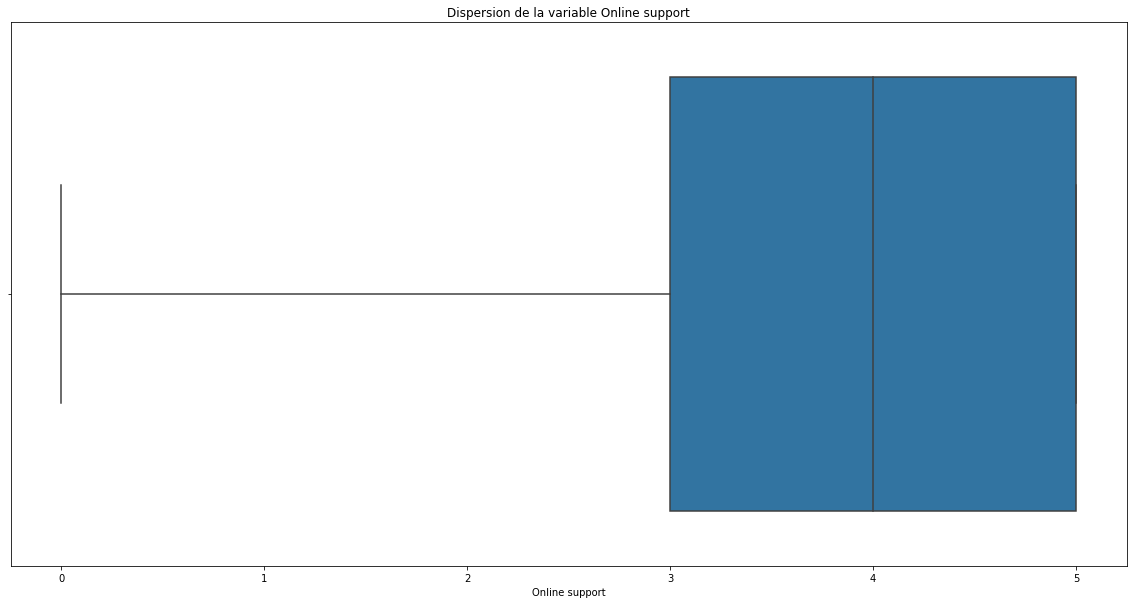

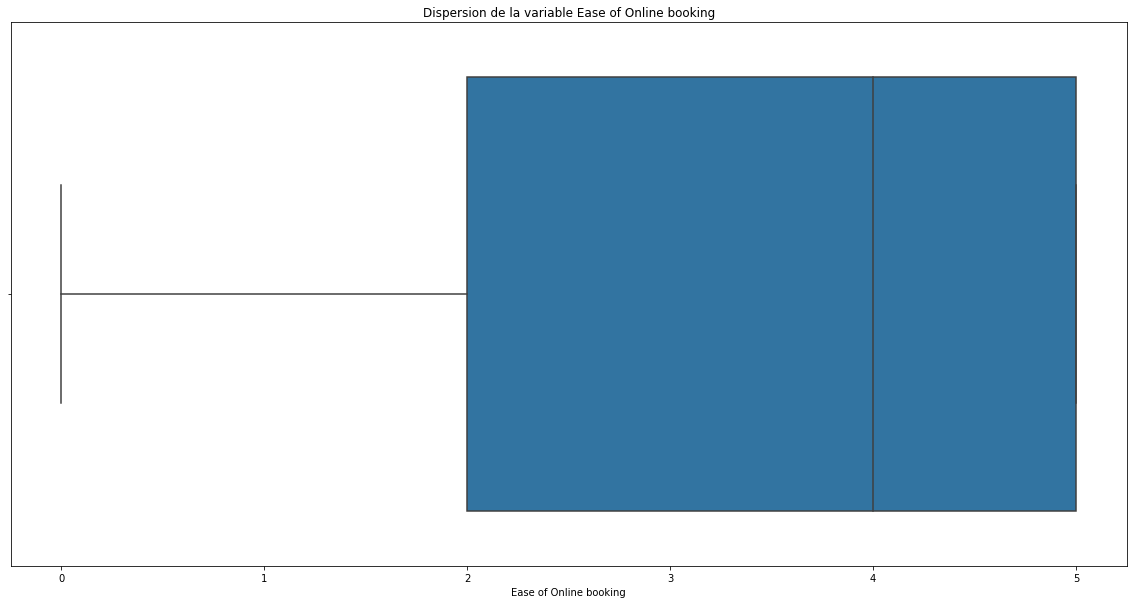

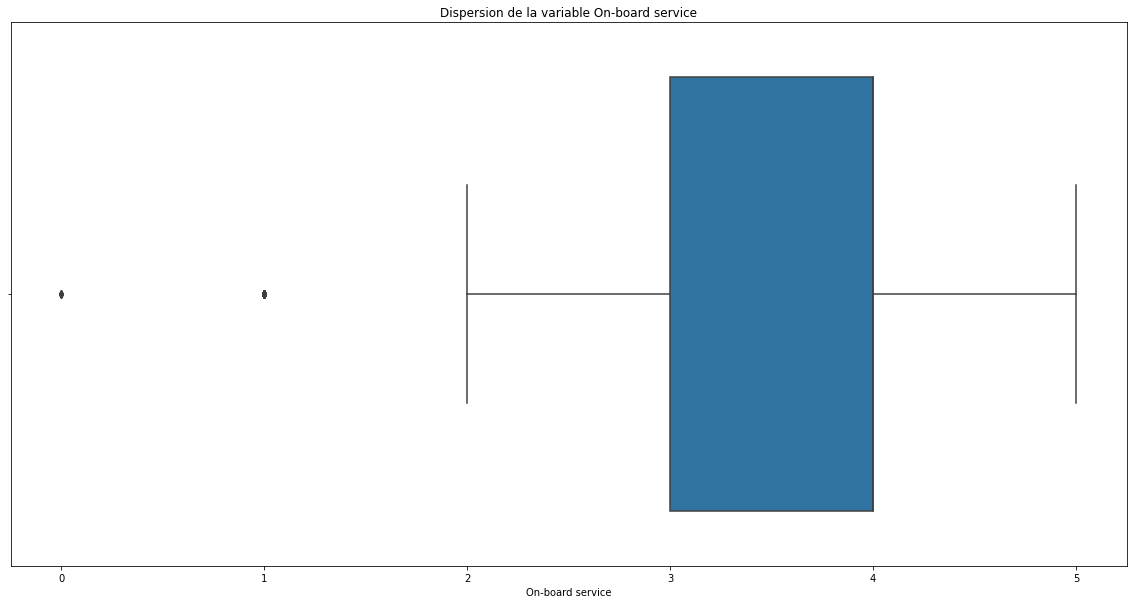

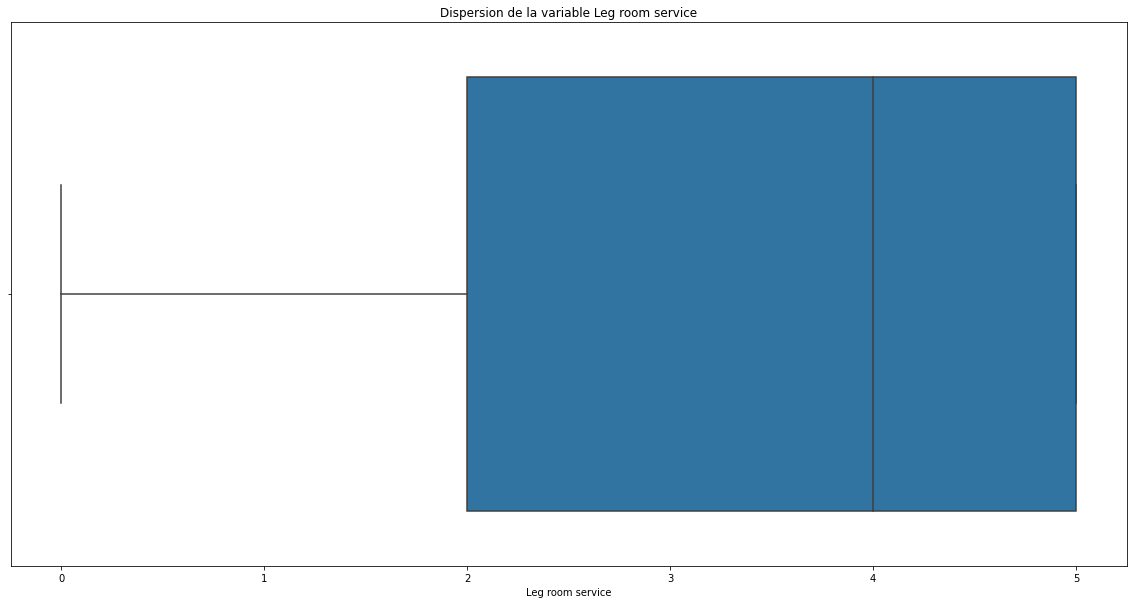

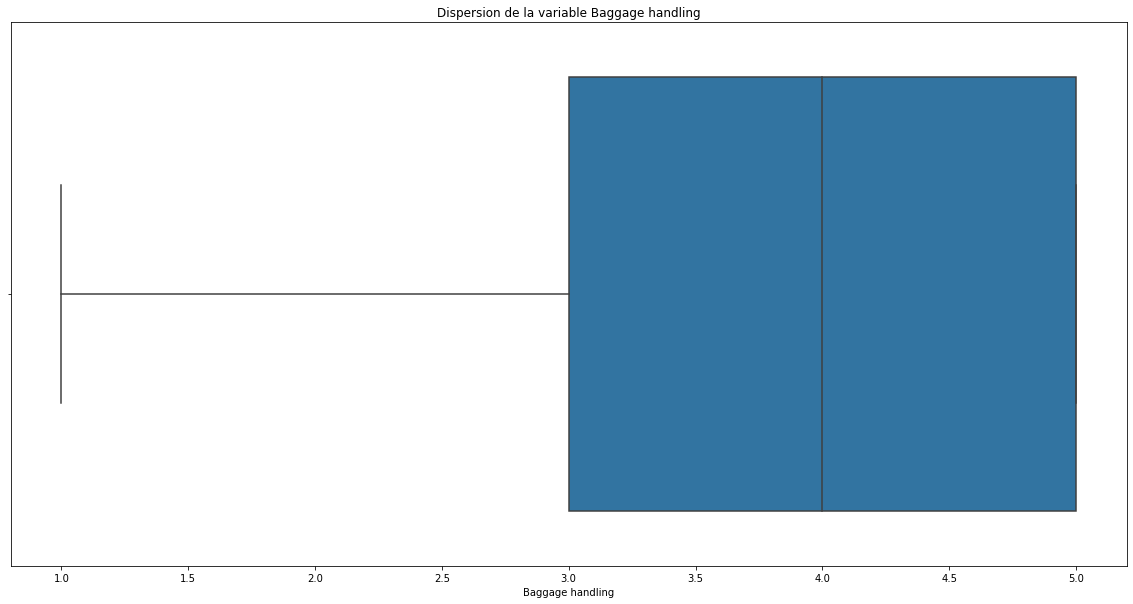

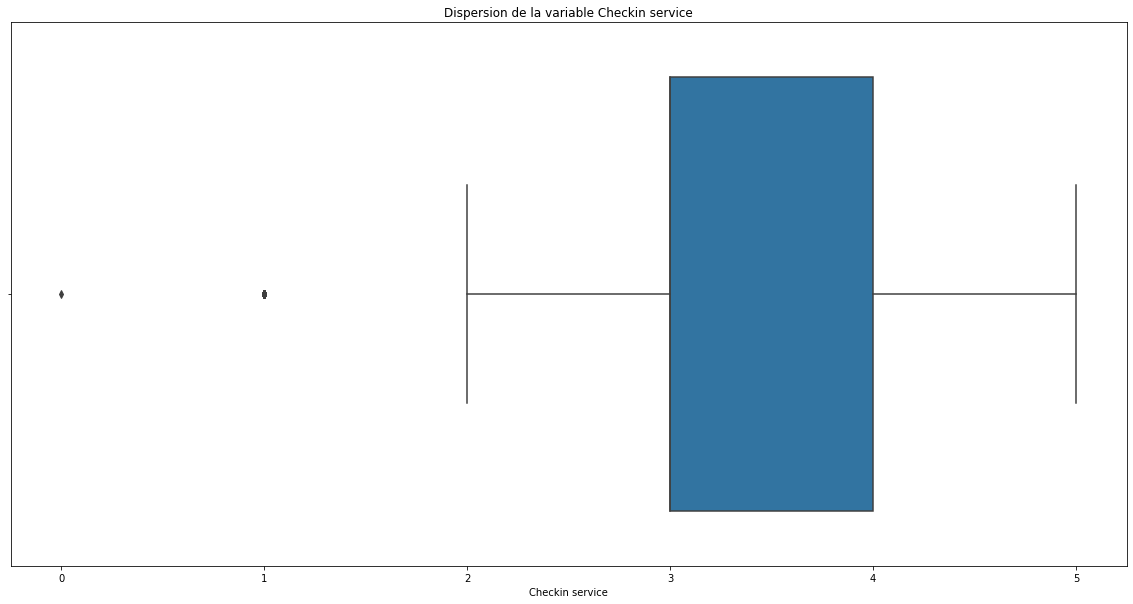

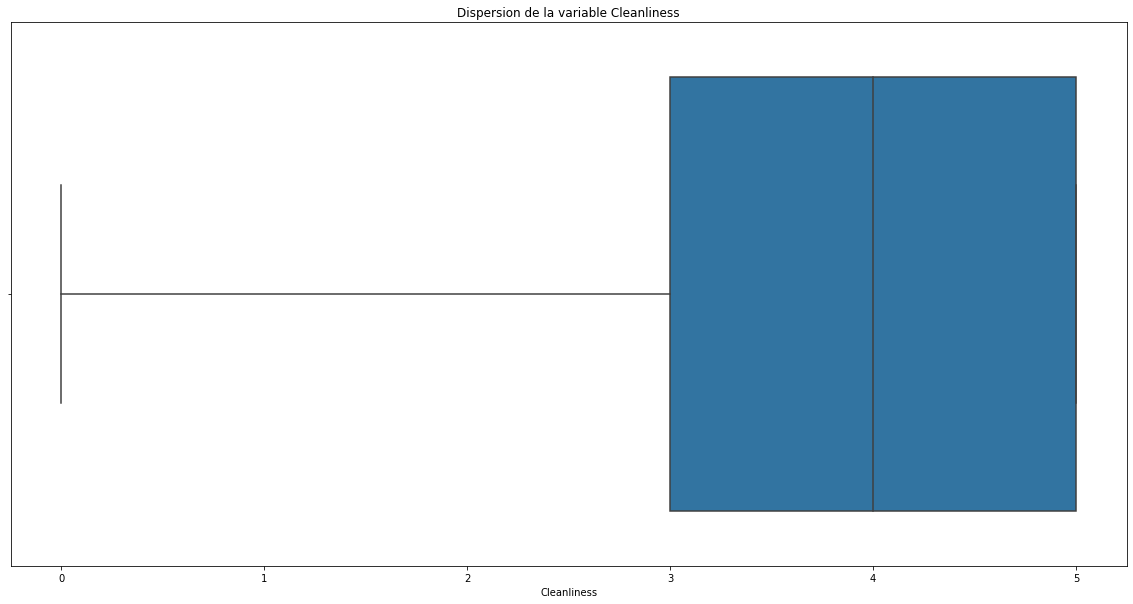

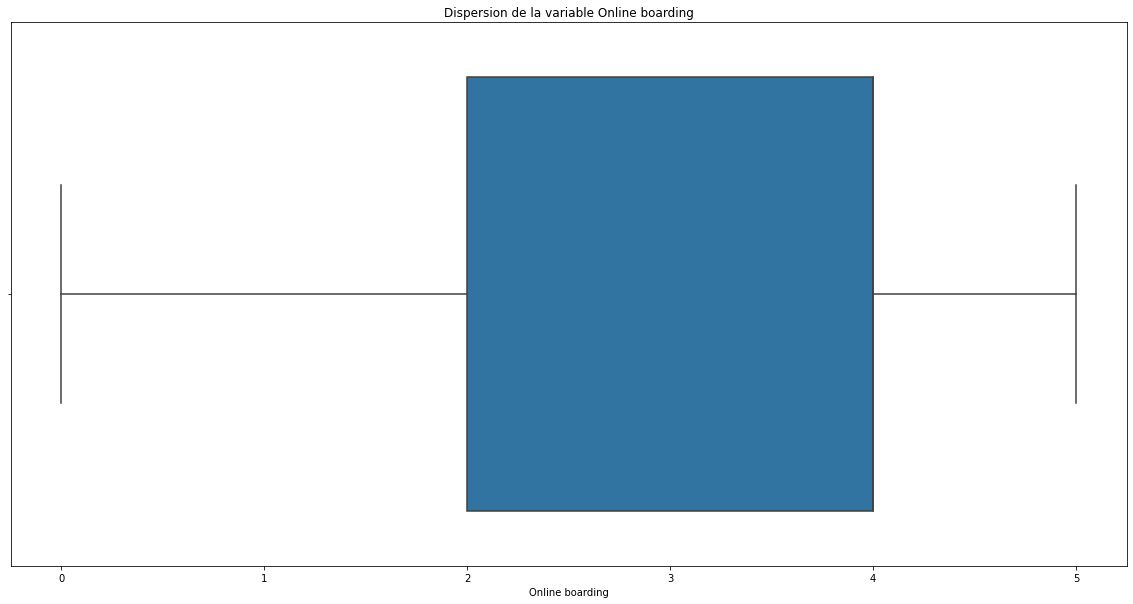

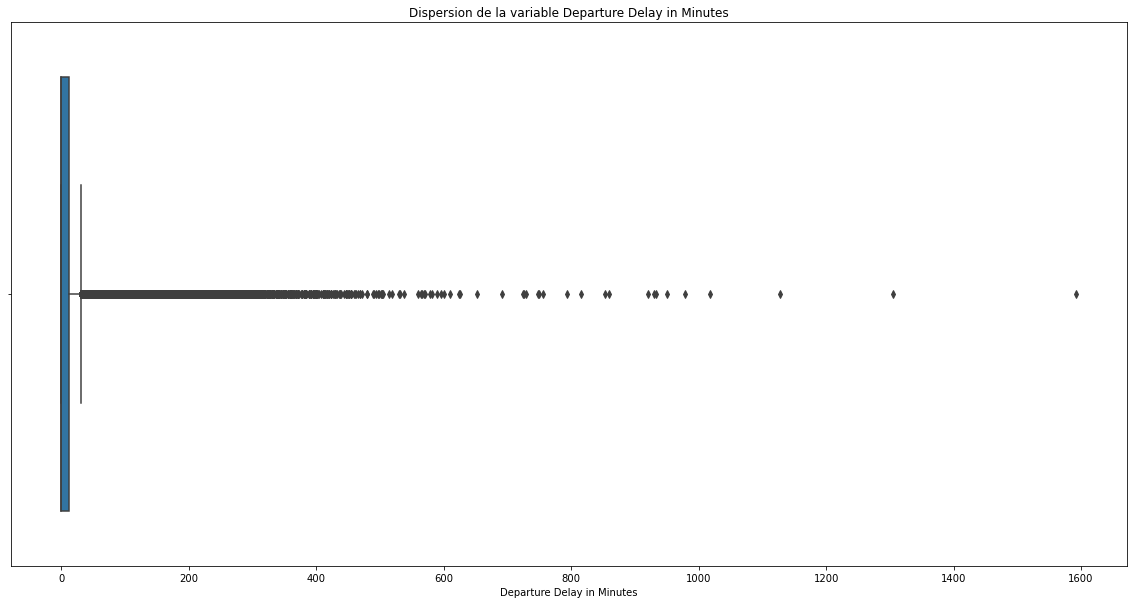

In [76]:
for cat in name:
    #plt.figure()
    Moustache(var_num,cat)
    #plt.title(cat)

In [77]:
var_num[['Flight Distance','Departure Delay in Minutes']].describe()

,Flight Distance,Departure Delay in Minutes
count,129880.000000,129880.000000
mean,1981.409055,14.713713
std,1027.115606,38.071126
min,50.000000,0.000000
25%,1359.000000,0.000000
50%,1925.000000,0.000000
75%,2544.000000,12.000000
max,6951.000000,1592.000000


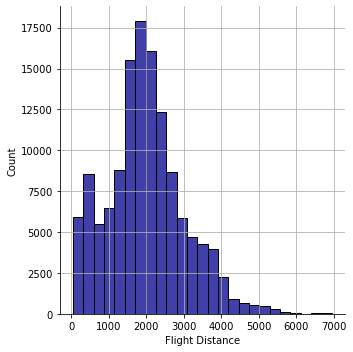

In [78]:
Histo('Flight Distance',var_num,25)

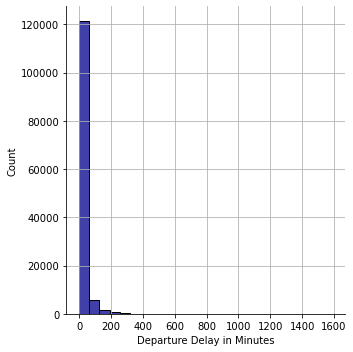

In [79]:
Histo('Departure Delay in Minutes',var_num,25)

In [80]:
#identiification valeur aberrantes
#calcul du premier quartile et du troisieme quartile 
Q1=var_num.quantile(0.25)
Q3=var_num.quantile(0.75)
IQR=Q3-Q1


#print(IQR)
#on ne peut pas utiliser 1.5 car les distributions ne sont pas symetriques
#essayons d'utiliser les valeurs 3 à 5 pour voir combien de données je perds
Nbreinter3=(var_num < (Q1 - 3 * IQR)) |(var_num > (Q3 + 3 * IQR))
Nbreinter4=(var_num < (Q1 - 4 * IQR)) |(var_num > (Q3 +  4 * IQR))
Nbreinter5=(var_num < (Q1 - 5 * IQR)) |(var_num > (Q3 +  5 * IQR))

In [81]:
l=var_num.columns
p=list(l)
type(p)
df=pd.DataFrame(p,columns=['Variables numeriques'])

In [82]:
df['Nombre de lignes perdus pour 3']=0
df['Nombre de lignes perdus pour 4']=0
df['Nombre de lignes perdus pour 5']=0

for j in range(0,df.shape[0]):
  i=Nbreinter3[df.iloc[j,0]]== True
  df.iloc[j,1]=Nbreinter3[df.iloc[j,0]][i].shape[0]
  u=Nbreinter4[df.iloc[j,0]]== True
  df.iloc[j,2]=Nbreinter4[df.iloc[j,0]][u].shape[0]
  v=Nbreinter5[df.iloc[j,0]]== True
  df.iloc[j,3]=Nbreinter5[df.iloc[j,0]][v].shape[0]


In [84]:
var_num.shape

(129880, 17)

In [86]:
cat_col.shape

(129880, 4)

In [83]:
df

,Variables numeriques,Nombre de lignes perdus pour 3,Nombre de lignes perdus pour 4,Nombre de lignes perdus pour 5
0,Age,0,0,0
1,Flight Distance,61,0,0
2,Seat comfort,0,0,0
3,Departure/Arrival time convenient,0,0,0
4,Food and drink,0,0,0
5,Gate location,0,0,0
6,Inflight wifi service,0,0,0
7,Inflight entertainment,0,0,0
8,Online support,0,0,0
9,Ease of Online booking,0,0,0


In [112]:
Q1=var_num.quantile(0.25)
Q3=var_num.quantile(0.75)
IQR=Q3-Q1
#~2 est egal à-3
#~ tilde permet de mettre la negation de ce qui suit
#on cherche les valeurs aberrantes des quon les a trouve on prend leur contraire en utilisan ~ 
#pour les afficher
num_data3 = var_num[~((var_num < (Q1 - 3 * IQR)) |(var_num > (Q3 + 3 * IQR))).any(axis=1)]
num_data4 = var_num[~((var_num < (Q1 - 4 * IQR)) |(var_num > (Q3 + 4 * IQR))).any(axis=1)]
num_data5 = var_num[~((var_num < (Q1 - 5 * IQR)) |(var_num > (Q3 +  5 * IQR))).any(axis=1)]
print('Pour un ecart de 3 on obtient',num_data3.shape,'Pour un ecart de 4 on obtient',num_data4.shape,
      'Pour un ecart de 5 on obtient', num_data5.shape)

Pour un ecart de 3 on obtient (118213, 17) Pour un ecart de 4 on obtient (120905, 17) Pour un ecart de 5 on obtient (122801, 17)


In [113]:
liste=[var_num.shape[0],num_data3.shape[0],num_data4.shape[0],num_data5.shape[0]]
df=pd.DataFrame(liste,index=['avec outlier','écart egal à 3','ecart egal à4','ecart egal à 5'],columns=['Nombre de lignes'])


In [114]:
df

,Nombre de lignes
avec outlier,129880
écart egal à 3,118213
ecart egal à4,120905
ecart egal à 5,122801


In [115]:
var_num.shape

(129880, 17)

In [116]:
#df
#df.iloc[0,0]
#df.iloc[1,0]
df['pourcentage']=0 #pourcentage represente le nombre de lignes qui restent
df['lignes perdus']=0
for i in range(0,df.shape[0]):
  df.iloc[i,1]=((df.iloc[i,0])*100/ df.iloc[0,0])
  df.iloc[i,2] = -(df.iloc[i,0])+(df.iloc[0,0])


In [117]:
df

,Nombre de lignes,pourcentage,lignes perdus
avec outlier,129880,100.000000,0
écart egal à 3,118213,91.017093,11667
ecart egal à4,120905,93.089775,8975
ecart egal à 5,122801,94.549584,7079


## Choix de l'interquartile 3

In [119]:
var_num.describe()

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000
mean,39.427957,1981.409055,2.838597,2.990645,2.851994,2.990422,3.249130,3.383477,3.519703,3.472105,3.465075,3.485902,3.695673,3.340807,3.705759,3.352587,14.713713
std,15.119360,1027.115606,1.392983,1.527224,1.443729,1.305970,1.318818,1.346059,1.306511,1.305560,1.270836,1.292226,1.156483,1.260582,1.151774,1.298715,38.071126
min,7.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1359.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000
50%,40.000000,1925.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000
75%,51.000000,2544.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,12.000000
max,85.000000,6951.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000


In [120]:
num_data3.describe()

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes
count,118213.000000,118213.000000,118213.000000,118213.000000,118213.000000,118213.000000,118213.000000,118213.000000,118213.000000,118213.00000,118213.000000,118213.000000,118213.000000,118213.000000,118213.000000,118213.000000,118213.000000
mean,39.453503,1957.466142,2.847792,2.990889,2.857139,2.989620,3.260208,3.395312,3.532353,3.48493,3.478585,3.487290,3.700803,3.348735,3.724294,3.361026,5.628611
std,15.121897,1012.484784,1.398902,1.529742,1.446538,1.307811,1.316295,1.344985,1.303448,1.30384,1.267616,1.295143,1.157929,1.257187,1.145382,1.296977,10.552249
min,7.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,27.000000,1337.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.00000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000
50%,40.000000,1904.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000
75%,51.000000,2522.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.00000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,6.000000
max,85.000000,6097.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,48.000000


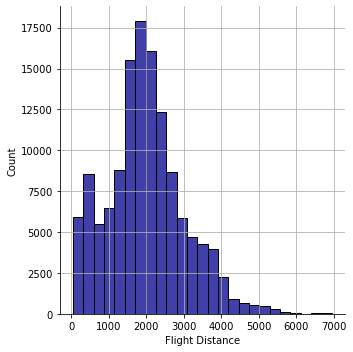

In [121]:
Histo('Flight Distance',var_num,25)

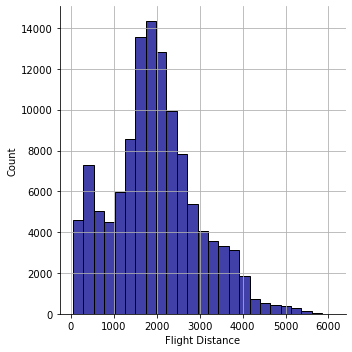

In [122]:
Histo('Flight Distance',num_data3,25)

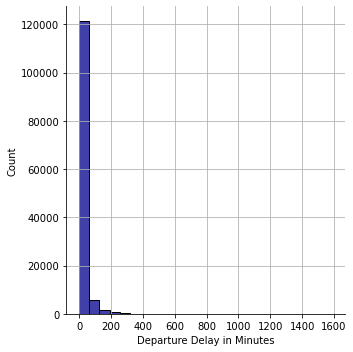

In [123]:
Histo('Departure Delay in Minutes',var_num,25)

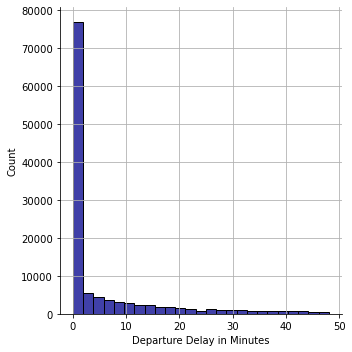

In [124]:
Histo('Departure Delay in Minutes',num_data3,25)

In [136]:
#le tableau des variables catégorielles
cat_col=data.select_dtypes('object')

In [137]:
cat_col.shape

(129880, 5)

In [138]:
var_num.shape

(129880, 17)

## Concaténation des deux tables 

In [421]:
dataPropre=pd.concat([cat_col,var_num],axis=1)

In [422]:
dataPropre.shape

(129880, 22)

In [423]:
dataPropre.isna().sum()

satisfaction                         0
Gender                               0
Customer Type                        0
Type of Travel                       0
Class                                0
Age                                  0
Flight Distance                      0
Seat comfort                         0
Departure/Arrival time convenient    0
Food and drink                       0
Gate location                        0
Inflight wifi service                0
Inflight entertainment               0
Online support                       0
Ease of Online booking               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Cleanliness                          0
Online boarding                      0
Departure Delay in Minutes           0
dtype: int64

## Etude outlier flight distance

In [560]:

outlier=CalculOutlier(dataPropre['Flight Distance'])
#outlier[0]#donne les index
#outlier[1]#donne les valeurs 

Donnez votre écart = 3
Voila votre résultat pour un ecart interquartile de 3.0


In [562]:
i=outlier[0]
dataPropre.loc[i,'Flight Distance'] 
dataPropre['Flight Distance'][i].describe()

count      61.000000
mean     6560.868852
std       261.423760
min      6117.000000
25%      6344.000000
50%      6588.000000
75%      6792.000000
max      6951.000000
Name: Flight Distance, dtype: float64

In [378]:
#suppression des 61 outliers 
#dataPropre=dataPropre.drop(index=i)

In [661]:
dataPropre.shape

(129880, 24)

## Etude outlier departure delay in minutes 

In [540]:
outlier=CalculOutlier(dataPropre['Departure Delay in Minutes'])
#outlier[0]#donne les index
#outlier[1]#donne les valeurs 

Donnez votre écart = 3
Voila votre résultat pour un ecart interquartile de 3.0


In [546]:
j=outlier[0]
dataPropre.loc[j,'Departure Delay in Minutes'].shape
dataPropre['Departure Delay in Minutes'][j].describe()

count    11608.000000
mean       107.275758
std         75.329379
min         49.000000
25%         62.000000
50%         83.000000
75%        125.000000
max       1592.000000
Name: Departure Delay in Minutes, dtype: float64

In [382]:
#suppression des 11606 outliers 
#dataPropre=dataPropre.drop(index=j)

In [383]:
dataPropre.shape

(129880, 22)

In [384]:
dataPropre.columns

Index(['satisfaction', 'Gender', 'Customer Type', 'Type of Travel', 'Class',
       'Age', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes'],
      dtype='object')

# Relations age et satisfaction

In [424]:
dataPropre.describe()

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000
mean,39.427957,1981.409055,2.838597,2.990645,2.851994,2.990422,3.249130,3.383477,3.519703,3.472105,3.465075,3.485902,3.695673,3.340807,3.705759,3.352587,14.713713
std,15.119360,1027.115606,1.392983,1.527224,1.443729,1.305970,1.318818,1.346059,1.306511,1.305560,1.270836,1.292226,1.156483,1.260582,1.151774,1.298715,38.071126
min,7.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1359.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000
50%,40.000000,1925.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000
75%,51.000000,2544.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,12.000000
max,85.000000,6951.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000


In [425]:
dataPropre['age_echelle'] = pd.cut(dataPropre['Age'], [0,18,35,50,65,85])
dataPropre.head(5)

,satisfaction,Gender,Customer Type,Type of Travel,Class,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,age_echelle
0,satisfied,Female,Loyal Customer,Personal Travel,Eco,65,265,0,0,0,...,2,3,3,0,3,5,3,2,0,"(50, 65]"
1,satisfied,Male,Loyal Customer,Personal Travel,Business,47,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,"(35, 50]"
2,satisfied,Female,Loyal Customer,Personal Travel,Eco,15,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,"(0, 18]"
3,satisfied,Female,Loyal Customer,Personal Travel,Eco,60,623,0,0,0,...,3,1,1,0,1,4,1,3,0,"(50, 65]"
4,satisfied,Female,Loyal Customer,Personal Travel,Eco,70,354,0,0,0,...,4,2,2,0,2,4,2,5,0,"(65, 85]"


In [426]:
age_groups = dataPropre.groupby(['satisfaction','age_echelle'])

In [427]:
age_groups=age_groups.size().unstack(0)#unstack

In [428]:
age_groups

satisfaction,dissatisfied,satisfied
age_echelle,,
"(0, 18]",6311,4759
"(18, 35]",21828,18847
"(35, 50]",17209,27324
"(50, 65]",10517,18040
"(65, 85]",2928,2117


In [429]:
age_groups['dsat']=(age_groups['dissatisfied']/(5560+19519+15310+9372+2612))*100

In [430]:
age_groups['sat']=(age_groups['satisfied']/(4485+17438+25232+16680+2005))*100

In [431]:
age_groups

satisfaction,dissatisfied,satisfied,dsat,sat
age_echelle,,,,
"(0, 18]",6311,4759,12.050102,7.228129
"(18, 35]",21828,18847,41.677964,28.625456
"(35, 50]",17209,27324,32.858534,41.500608
"(50, 65]",10517,18040,20.080958,27.399757
"(65, 85]",2928,2117,5.590667,3.215371


In [432]:
age_groups.index.astype(str)

Index(['(0, 18]', '(18, 35]', '(35, 50]', '(50, 65]', '(65, 85]'], dtype='object', name='age_echelle')

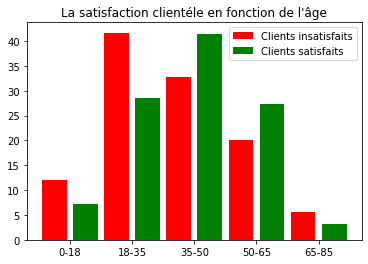

In [665]:
plt.figure()
X = np.arange(len(age_groups.index.astype(str)))
plt.bar(X,age_groups['dsat'] , width=0.4,
                label="Clients insatisfaits",align='center',color='red')

plt.bar(X+0.5, age_groups['sat'], width=0.4,label="Clients satisfaits",align='center',color='green')

plt.xticks([i + 0.25 for i in range(5)], ['0-18', '18-35', '35-50', '50-65', '65-85'])
plt.legend()
plt.title("La satisfaction clientéle en fonction de l'âge")
plt.show()

In [434]:
dataPropre.shape

(129880, 23)

In [435]:
dataPropre.columns

Index(['satisfaction', 'Gender', 'Customer Type', 'Type of Travel', 'Class',
       'Age', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'age_echelle'],
      dtype='object')

# Choix du target 

In [436]:
dataPropre['satisfaction'].value_counts()

satisfied       71087
dissatisfied    58793
Name: satisfaction, dtype: int64

In [437]:
satisfaction=LabelEncoder().fit_transform(dataPropre['satisfaction'])

In [438]:
dataPropre['label_satisfaction']=satisfaction

In [439]:
dataPropre['label_satisfaction'].value_counts()

1    71087
0    58793
Name: label_satisfaction, dtype: int64

# Encodage des variables catégorielles

In [440]:
dataPropre.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

satisfaction      2
Gender            2
Customer Type     2
Type of Travel    2
Class             3
dtype: int64

In [442]:
var_cat=dataPropre.select_dtypes('object').drop(columns='satisfaction')
#suppression de la variable catégorielle satisfaction qui etait encodé en 0 et 1

In [443]:
var_cat.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Gender            2
Customer Type     2
Type of Travel    2
Class             3
dtype: int64

In [444]:
var_cat['Gender'].value_counts()

Female    65899
Male      63981
Name: Gender, dtype: int64

In [445]:
var_cat['Customer Type'].value_counts()

Loyal Customer       106100
disloyal Customer     23780
Name: Customer Type, dtype: int64

In [446]:
var_cat['Type of Travel'].value_counts()

Business travel    89693
Personal Travel    40187
Name: Type of Travel, dtype: int64

## Encodage avec label encoder 

In [447]:
le = LabelEncoder()
le_count = 0 #pour compter le nombre de features a encoder

for col in var_cat.columns:
    if var_cat[col].dtype == 'object':
        
        if len(list(var_cat[col].unique())) <= 2:
            
            le.fit(var_cat[col])
            
            var_cat[col] = le.transform(var_cat[col])
            
            
            
            
            le_count += 1

print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [448]:
var_cat['Gender'].value_counts()

0    65899
1    63981
Name: Gender, dtype: int64

In [449]:
var_cat['Customer Type'].value_counts()

0    106100
1     23780
Name: Customer Type, dtype: int64

In [450]:
var_cat['Type of Travel'].value_counts()

0    89693
1    40187
Name: Type of Travel, dtype: int64

## Encodage avec onehotencoder

In [451]:
var_cat.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Class    3
dtype: int64

In [452]:
var_cat['Class'].value_counts()

Business    62160
Eco         58309
Eco Plus     9411
Name: Class, dtype: int64

In [453]:
var_cat.shape

(129880, 4)

In [454]:
var_cat = pd.get_dummies(var_cat)

In [455]:
var_cat.shape

(129880, 6)

In [456]:
var_cat.columns

Index(['Gender', 'Customer Type', 'Type of Travel', 'Class_Business',
       'Class_Eco', 'Class_Eco Plus'],
      dtype='object')

In [459]:
dataPropre['age_echelle'].dtypes

CategoricalDtype(categories=[(0, 18], (18, 35], (35, 50], (50, 65], (65, 85]], ordered=True)

In [461]:
var_cat.shape

(129880, 6)

In [464]:
num_var=dataPropre.select_dtypes(['float','int'])

In [465]:
num_var.shape

(129880, 18)

# Notre base finale avec outlier 

In [468]:
dataModel=pd.concat([var_cat,num_var],axis=1)

In [469]:
dataModel.shape

(129880, 24)

In [470]:
dataModel.columns

Index(['Gender', 'Customer Type', 'Type of Travel', 'Class_Business',
       'Class_Eco', 'Class_Eco Plus', 'Age', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'label_satisfaction'],
      dtype='object')

# Corrélation avec la variable target 

In [471]:
cor=dataModel.corr()['label_satisfaction'].sort_values()
#corrélation de nos variables avec notre target 

In [476]:
# display correlations
print('Les features avec une correlation: \n', cor.tail(24))

Les features avec une correlation: 
 Customer Type                       -0.292592
Class_Eco                           -0.278062
Gender                              -0.212236
Type of Travel                      -0.109239
Departure Delay in Minutes          -0.073909
Class_Eco Plus                      -0.067537
Flight Distance                     -0.039224
Departure/Arrival time convenient   -0.015507
Gate location                       -0.012071
Age                                  0.117971
Food and drink                       0.120677
Inflight wifi service                0.227062
Seat comfort                         0.242384
Cleanliness                          0.259330
Baggage handling                     0.260347
Checkin service                      0.266179
Leg room service                     0.304928
Class_Business                       0.311912
Online boarding                      0.338147
On-board service                     0.352047
Online support                       0.3901

# Séparation de nos données en X et Y

In [605]:
X = dataModel.drop(['label_satisfaction'], axis=1)
Y = dataModel['label_satisfaction']

In [478]:
X.head()

,Gender,Customer Type,Type of Travel,Class_Business,Class_Eco,Class_Eco Plus,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes
0,0,0,1,0,1,0,65,265,0,0,...,4,2,3,3,0,3,5,3,2,0
1,1,0,1,1,0,0,47,2464,0,0,...,2,2,3,4,4,4,2,3,2,310
2,0,0,1,0,1,0,15,2138,0,0,...,0,2,2,3,3,4,4,4,2,0
3,0,0,1,0,1,0,60,623,0,0,...,4,3,1,1,0,1,4,1,3,0
4,0,0,1,0,1,0,70,354,0,0,...,3,4,2,2,0,2,4,2,5,0


In [606]:
Y.value_counts()

1    71087
0    58793
Name: label_satisfaction, dtype: int64

# Décomposition en train, test et standarisation

## Décomposition 

In [483]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=6)

In [484]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((103904, 23), (25976, 23), (103904,), (25976,))

## Standarisation

In [488]:
std_scale=RobustScaler().fit(X_train)
#entrainement sur le train pour éviter le suréchatillonnage

In [489]:
X_scale_train=std_scale.transform(X_train)
#transformation du train

In [490]:
X_scale_test=std_scale.transform(X_test)
#transformation du test

In [492]:
X_scale_test.mean(),X_scale_test.std()

(0.06291834052312628, 0.9779512350643681)

In [493]:
X_scale_train.shape,y_train.shape

((103904, 23), (103904,))

## Rééchatillonnage

In [494]:
X_scale_train.shape,y_train.shape

((103904, 23), (103904,))

In [495]:
# SMOTE
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_scale_train, y_train)

In [496]:
X_sm.shape,y_sm.shape

((113570, 23), (113570,))

# Modéle de random Forest

In [501]:
model=RandomForestClassifier()

#la fonction pour mesurer la qualite d'un split est gini
#n_estimators= le nombre d'arbre
#min_sample split Le nombre minimum d'échantillons requis pour diviser un nœud interne
#max_depth est la profondeur de l'arbre
params = {'n_estimators':[100,150],'max_depth':[6,8]}

cv=StratifiedKFold(n_splits=5)
grid1=GridSearchCV(model,param_grid=params,cv=cv,return_train_score=True,scoring='f1')

In [502]:
grid1.fit(X_sm,y_sm)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [6, 8], 'n_estimators': [100, 150]},
             return_train_score=True, scoring='f1')

In [503]:
#le meilleur parametre 
grid1.best_params_

{'max_depth': 8, 'n_estimators': 150}

In [504]:
#le meilleur estimateur
grid1.best_estimator_

RandomForestClassifier(max_depth=8, n_estimators=150)

In [505]:
grid1.best_score_#f_betascore

0.9197344744492071

In [506]:
model_random=grid1.best_estimator_
#c'est notre meilleur estimateur 

## Métriques matrice de confusion

In [509]:
y_predict = model_random.predict(X_scale_test) #predict

In [513]:
logi_confusion = me.confusion_matrix(y_test, y_predict) 

In [514]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91     11674
           1       0.92      0.93      0.93     14302

    accuracy                           0.92     25976
   macro avg       0.92      0.92      0.92     25976
weighted avg       0.92      0.92      0.92     25976



In [526]:
cls_labels_transform = conf_mat_transform(y_test, y_predict)
conf_mat = me.confusion_matrix(y_test, y_predict)


Text(69.0, 0.5, 'Classe prédite')

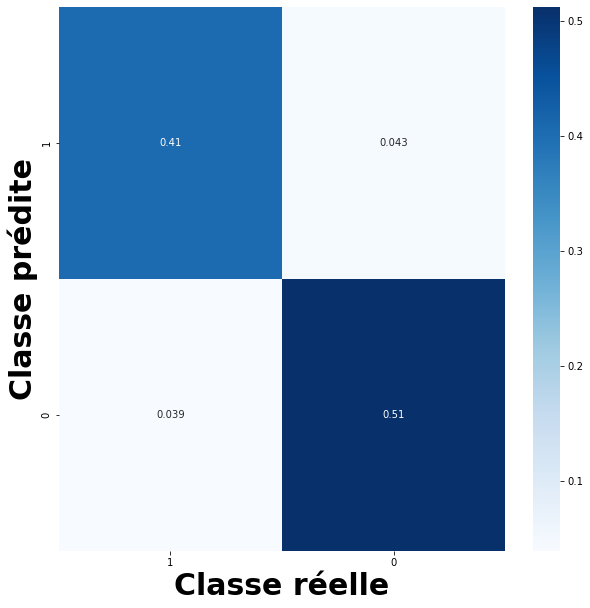

In [528]:
df_cm = pd.DataFrame(conf_mat/y_test.shape[0], index = [label for label in dataModel['label_satisfaction'].value_counts().index ],
                  columns = [i for i in dataModel['label_satisfaction'].value_counts().index ])
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.xlabel('Classe réelle',fontsize = 30, fontweight = 'bold')
plt.ylabel('Classe prédite',fontsize = 30, fontweight = 'bold')

In [517]:
precisionRandom=accuracy_score(y_test, y_predict)

In [518]:
precisionRandom

0.9178087465352633

## Comparaison bayésienne 

In [520]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_sm,y_sm)

DummyClassifier(strategy='most_frequent')

In [521]:
y_pred_dum=dummy_clf.predict(X_scale_test)


In [522]:
precisiondummy=accuracy_score(y_test, y_pred_dum)

In [523]:
precisiondummy

0.4494148444718201

## Courbe AUROC

,thr,tpr,fpr
0,2,0.00000,0.000000
1,1,0.92945,0.096454
2,0,1.00000,1.000000


AUC : 0.9783180406305289


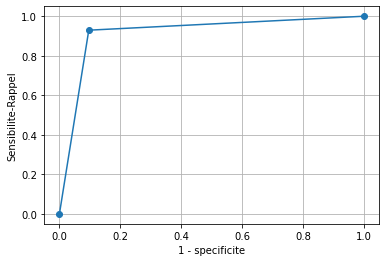

In [531]:

[fpr, tpr, thr]  = me.roc_curve(y_test, model_random.predict(X_scale_test))
#1-fpr correspond a la antispecifite pour la vrais specifite 1-valeur
#tpr le rappel , sensibilité
#thr le seuil 

df_roc = pd.DataFrame({'thr': thr, 'tpr': tpr, 'fpr': fpr})
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1 - specificite')
plt.ylabel('Sensibilite-Rappel')
plt.grid()
display(df_roc)
#ceci est notre AUROC qui permet de comparer 
AUROCRandom=roc_auc_score(y_test, model_random.predict_proba(X_scale_test)[:, 1])

print('AUC : {}'.format(roc_auc_score(y_test, model_random.predict_proba(X_scale_test)[:, 1])))


# Features importances 

In [532]:
df4=pd.DataFrame({'Features':X.columns,'Features_importances':model_random.feature_importances_})
df4.sort_values('Features_importances')

,Features,Features_importances
5,Class_Eco Plus,0.000605
22,Departure Delay in Minutes,0.002734
6,Age,0.005800
11,Gate location,0.008119
7,Flight Distance,0.008326
12,Inflight wifi service,0.010880
9,Departure/Arrival time convenient,0.011827
19,Checkin service,0.016633
20,Cleanliness,0.016993
4,Class_Eco,0.018510


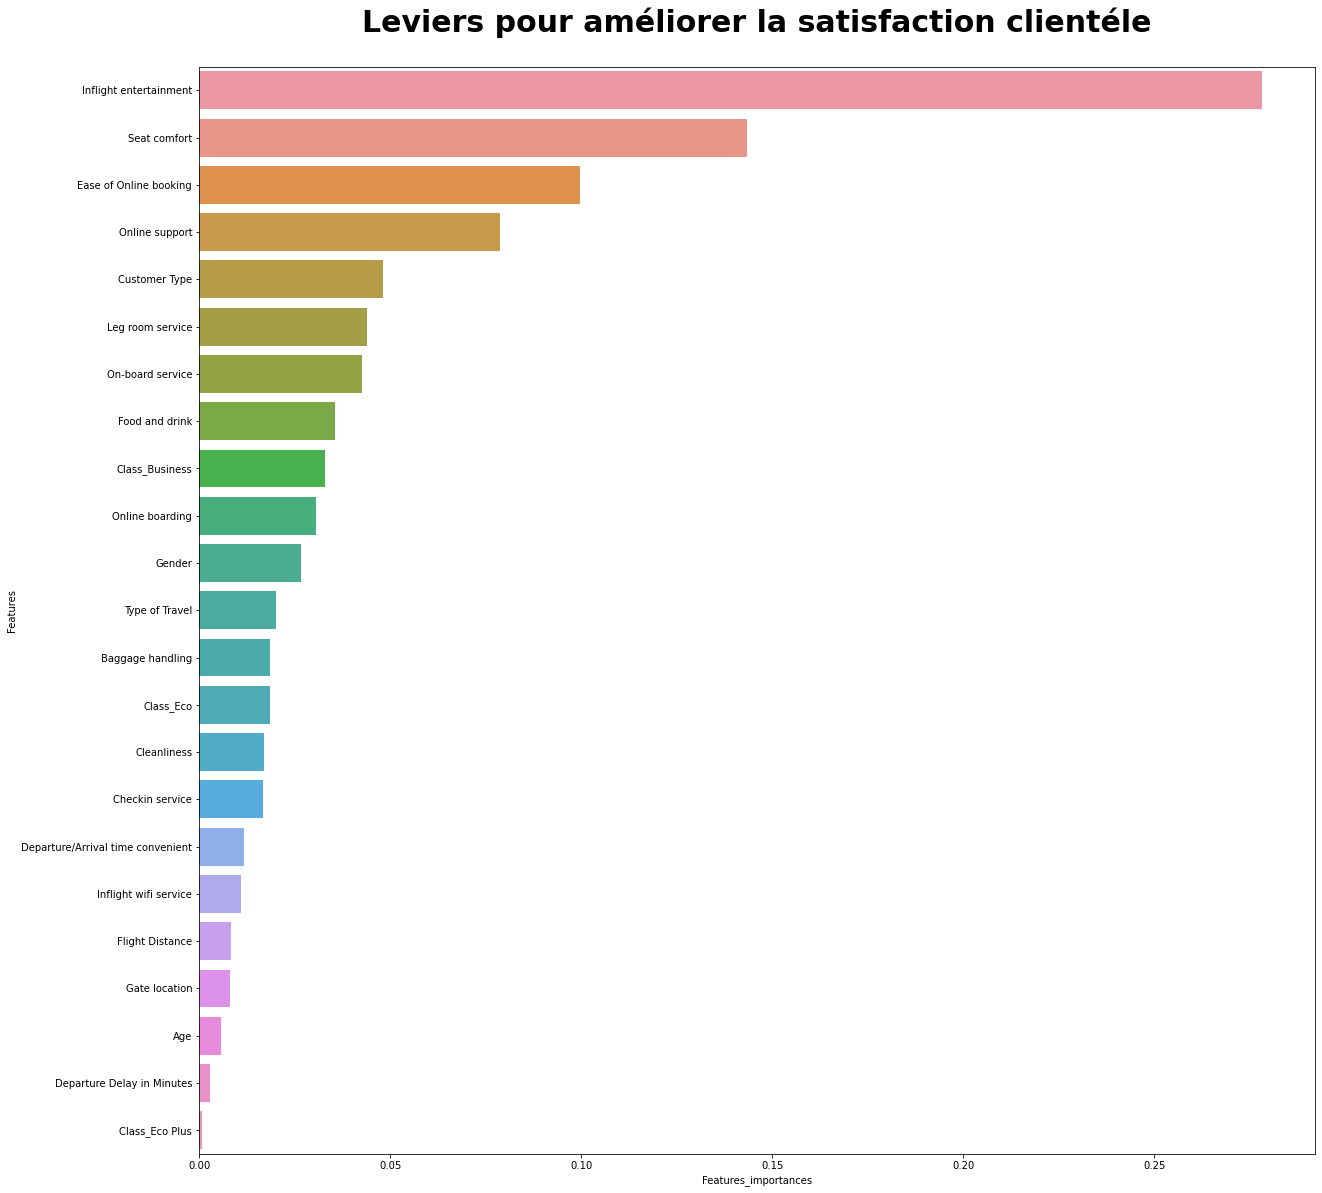

In [534]:
plt.figure(figsize=(20,20))
plt.title('Leviers pour améliorer la satisfaction clientéle',fontsize = 30, pad = 35, fontweight = 'bold')
sns.barplot(y='Features',x='Features_importances',data=df4.sort_values('Features_importances',ascending=False))
plt.show()

# Amélioration du modéle random

In [607]:
X.columns

Index(['Gender', 'Customer Type', 'Type of Travel', 'Class_Business',
       'Class_Eco', 'Class_Eco Plus', 'Age', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes'],
      dtype='object')

Text(0.5, 1.0, 'Le Délai de départ est de 0 mn en minimum et 1592 en maximum')

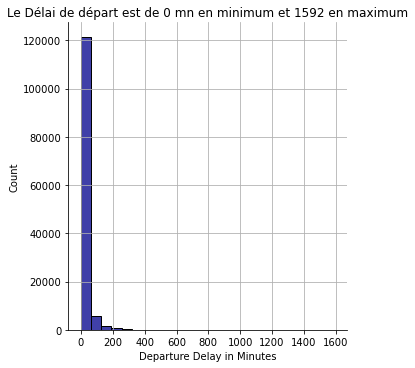

In [610]:
Histo('Departure Delay in Minutes',X,25)
plt.title('Le Délai de départ est de 0 mn en minimum et 1592 en maximum')

In [547]:
X['Departure Delay in Minutes'].describe()

count    129880.000000
mean         14.713713
std          38.071126
min           0.000000
25%           0.000000
50%           0.000000
75%          12.000000
max        1592.000000
Name: Departure Delay in Minutes, dtype: float64

Text(0.5, 1.0, 'La distance de vol est de 50 en minimum et 6951 en maximum')

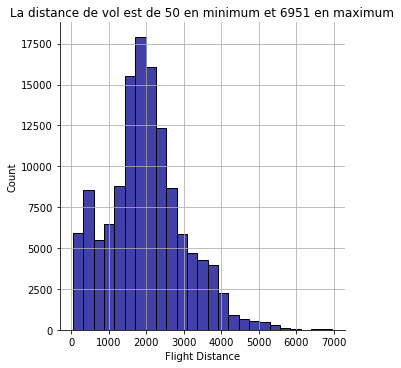

In [615]:
Histo('Flight Distance',X,25)
plt.title('La distance de vol est de 50 en minimum et 6951 en maximum')

In [559]:
X['Flight Distance'].describe()

count    129880.000000
mean       1981.409055
std        1027.115606
min          50.000000
25%        1359.000000
50%        1925.000000
75%        2544.000000
max        6951.000000
Name: Flight Distance, dtype: float64

Text(0.5, 1.0, 'Le voyageur le plus jeune est âgé de 7 ans et le plus vieux est de 85 ans')

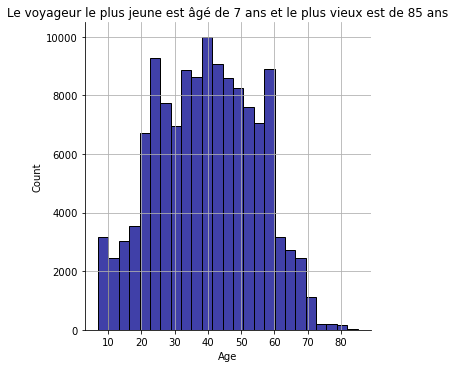

In [619]:
Histo('Age',X,25)
plt.title('Le voyageur le plus jeune est âgé de 7 ans et le plus vieux est de 85 ans')

In [568]:
X['Age'].describe()

count    129880.000000
mean         39.427957
std          15.119360
min           7.000000
25%          27.000000
50%          40.000000
75%          51.000000
max          85.000000
Name: Age, dtype: float64

## Classes de departure delay in minutes 

In [611]:
bin_label=['Attente_normal','Attente_moyen','Attente_élevé']
X['Attente'] = pd.cut(x=X['Departure Delay in Minutes'], bins=[-1,49,83,1592],right=True,labels=bin_label)

Text(0.5, 1.0, 'Regroupement en trois classes')

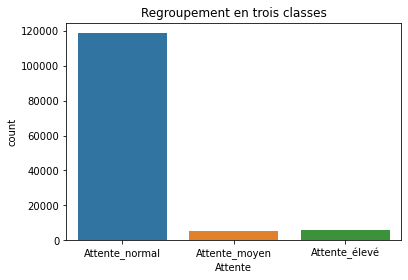

In [613]:
sns.countplot(x=X['Attente'])
plt.title('Regroupement en trois classes')

In [558]:
X[['Attente','Departure Delay in Minutes']].tail(12)

,Attente,Departure Delay in Minutes
129868,Attente_normal,0
129869,Attente_normal,0
129870,Attente_moyen,54
129871,Attente_normal,9
129872,Attente_normal,4
129873,Attente_normal,7
129874,Attente_normal,5
129875,Attente_normal,0
129876,Attente_élevé,174
129877,Attente_élevé,155


## Classes flight distance 

In [617]:
bin_label=['Vol_court','Vol_moyen','Vol_long']
X['Durée'] = pd.cut(x=X['Flight Distance'], bins=[49,1000,4000,6951],right=True,labels=bin_label)

Text(0.5, 1.0, 'Regroupement en trois classes')

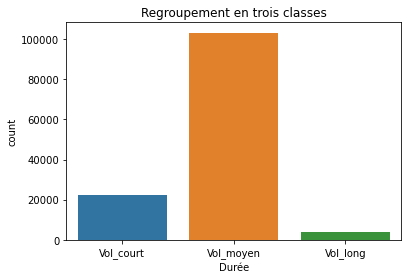

In [618]:
sns.countplot(x=X['Durée'])
plt.title('Regroupement en trois classes')

In [567]:
X[['Durée','Flight Distance']].head(12)

,Durée,Flight Distance
0,Vol_court,265
1,Vol_moyen,2464
2,Vol_moyen,2138
3,Vol_court,623
4,Vol_court,354
5,Vol_moyen,1894
6,Vol_court,227
7,Vol_moyen,1812
8,Vol_court,73
9,Vol_moyen,1556


## Classes d'age

In [620]:
bin_label=['Enfants','Adolescents','Adultes','Ainés']
X['Tranche_Age'] = pd.cut(x=X['Age'], bins=[6,14,25,64,86],right=True,labels=bin_label)

In [621]:
X[['Tranche_Age','Age']].tail(12)

,Tranche_Age,Age
129868,Adultes,45
129869,Adultes,55
129870,Ainés,70
129871,Adultes,35
129872,Ainés,69
129873,Adultes,63
129874,Enfants,11
129875,Adultes,29
129876,Adultes,63
129877,Ainés,69


Text(0.5, 1.0, 'Regroupement en quatre classes')

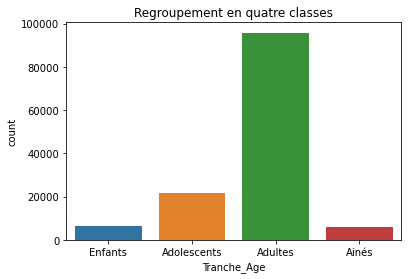

In [623]:
sns.countplot(x=X['Tranche_Age'])
plt.title('Regroupement en quatre classes')

## Suppression variables d'origine

In [572]:
X.columns

Index(['Gender', 'Customer Type', 'Type of Travel', 'Class_Business',
       'Class_Eco', 'Class_Eco Plus', 'Age', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Attente', 'Durée', 'Tranche_Age'],
      dtype='object')

In [573]:
X=X.drop(columns=['Age','Departure Delay in Minutes','Flight Distance'])

In [574]:
X.columns

Index(['Gender', 'Customer Type', 'Type of Travel', 'Class_Business',
       'Class_Eco', 'Class_Eco Plus', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Attente', 'Durée', 'Tranche_Age'],
      dtype='object')

In [576]:
X.head()

,Gender,Customer Type,Type of Travel,Class_Business,Class_Eco,Class_Eco Plus,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Attente,Durée,Tranche_Age
0,0,0,1,0,1,0,0,0,0,2,...,3,3,0,3,5,3,2,Attente_normal,Vol_court,Ainés
1,1,0,1,1,0,0,0,0,0,3,...,3,4,4,4,2,3,2,Attente_élevé,Vol_moyen,Adultes
2,0,0,1,0,1,0,0,0,0,3,...,2,3,3,4,4,4,2,Attente_normal,Vol_moyen,Adolescents
3,0,0,1,0,1,0,0,0,0,3,...,1,1,0,1,4,1,3,Attente_normal,Vol_court,Adultes
4,0,0,1,0,1,0,0,0,0,3,...,2,2,0,2,4,2,5,Attente_normal,Vol_court,Ainés


In [579]:
X['Attente']=X['Attente'].astype('object')
X['Durée']=X['Durée'].astype('object')
X['Tranche_Age']=X['Tranche_Age'].astype('object')


In [581]:
X['Durée'].value_counts()

Vol_moyen    103156
Vol_court     22572
Vol_long       4152
Name: Durée, dtype: int64

In [577]:
X['Attente'].value_counts()

Attente_normal    118514
Attente_élevé       5799
Attente_moyen       5567
Name: Attente, dtype: int64

In [582]:
X['Tranche_Age'].value_counts()

Adultes        95724
Adolescents    21713
Enfants         6460
Ainés           5983
Name: Tranche_Age, dtype: int64

## Encodage new features

In [583]:
X.shape

(129880, 23)

In [580]:
X.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Attente        3
Durée          3
Tranche_Age    4
dtype: int64

In [584]:
X = pd.get_dummies(X)

In [585]:
X.shape

(129880, 30)

In [587]:
X.columns

Index(['Gender', 'Customer Type', 'Type of Travel', 'Class_Business',
       'Class_Eco', 'Class_Eco Plus', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Attente_Attente_moyen', 'Attente_Attente_normal',
       'Attente_Attente_élevé', 'Durée_Vol_court', 'Durée_Vol_long',
       'Durée_Vol_moyen', 'Tranche_Age_Adolescents', 'Tranche_Age_Adultes',
       'Tranche_Age_Ainés', 'Tranche_Age_Enfants'],
      dtype='object')

In [588]:
Y.shape

(129880,)

## Décomposition, standarisation et rééchatillonage

In [589]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=6)

In [590]:
std_scale=RobustScaler().fit(X_train)
#entrainement sur le train pour éviter le suréchatillonnage

In [591]:
X_scale_train=std_scale.transform(X_train)
X_scale_test=std_scale.transform(X_test)
# SMOTE
#smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_scale_train, y_train)

## Modéle random amélioré

In [592]:
model=RandomForestClassifier()

#la fonction pour mesurer la qualite d'un split est gini
#n_estimators= le nombre d'arbre
#min_sample split Le nombre minimum d'échantillons requis pour diviser un nœud interne
#max_depth est la profondeur de l'arbre
params = {'n_estimators':[100,150],'max_depth':[6,8]}

cv=StratifiedKFold(n_splits=5)
grid1=GridSearchCV(model,param_grid=params,cv=cv,return_train_score=True,scoring='f1')

In [593]:
grid1.fit(X_sm,y_sm)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [6, 8], 'n_estimators': [100, 150]},
             return_train_score=True, scoring='f1')

In [594]:
model_random2=grid1.best_estimator_

## Métriques 

In [595]:
y_predict = model_random2.predict(X_scale_test) #predict

In [596]:
logi_confusion = me.confusion_matrix(y_test, y_predict) 

In [597]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91     11674
           1       0.92      0.93      0.93     14302

    accuracy                           0.92     25976
   macro avg       0.92      0.92      0.92     25976
weighted avg       0.92      0.92      0.92     25976



In [598]:
cls_labels_transform = conf_mat_transform(y_test, y_predict)
conf_mat = me.confusion_matrix(y_test, y_predict)

Text(69.0, 0.5, 'Classe prédite')

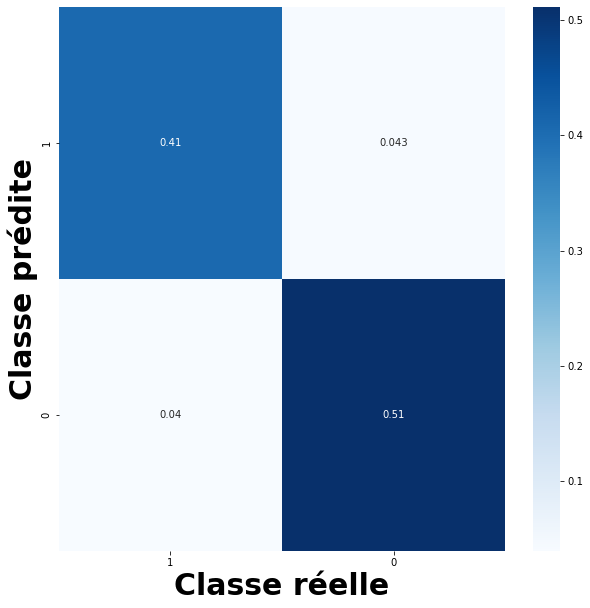

In [599]:
df_cm = pd.DataFrame(conf_mat/y_test.shape[0], index = [label for label in dataModel['label_satisfaction'].value_counts().index ],
                  columns = [i for i in dataModel['label_satisfaction'].value_counts().index ])
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.xlabel('Classe réelle',fontsize = 30, fontweight = 'bold')
plt.ylabel('Classe prédite',fontsize = 30, fontweight = 'bold')

In [601]:
precisionRandom2=accuracy_score(y_test, y_predict)

In [602]:
precisionRandom2

0.9176162611641515

## Features importance

In [603]:
df4=pd.DataFrame({'Features':X.columns,'Features_importances':model_random2.feature_importances_})
df4.sort_values('Features_importances')

,Features,Features_importances
20,Attente_Attente_moyen,0.000058
29,Tranche_Age_Enfants,0.000219
28,Tranche_Age_Ainés,0.000264
24,Durée_Vol_long,0.000359
21,Attente_Attente_normal,0.000490
5,Class_Eco Plus,0.000566
22,Attente_Attente_élevé,0.001315
26,Tranche_Age_Adolescents,0.001340
27,Tranche_Age_Adultes,0.001448
25,Durée_Vol_moyen,0.004182


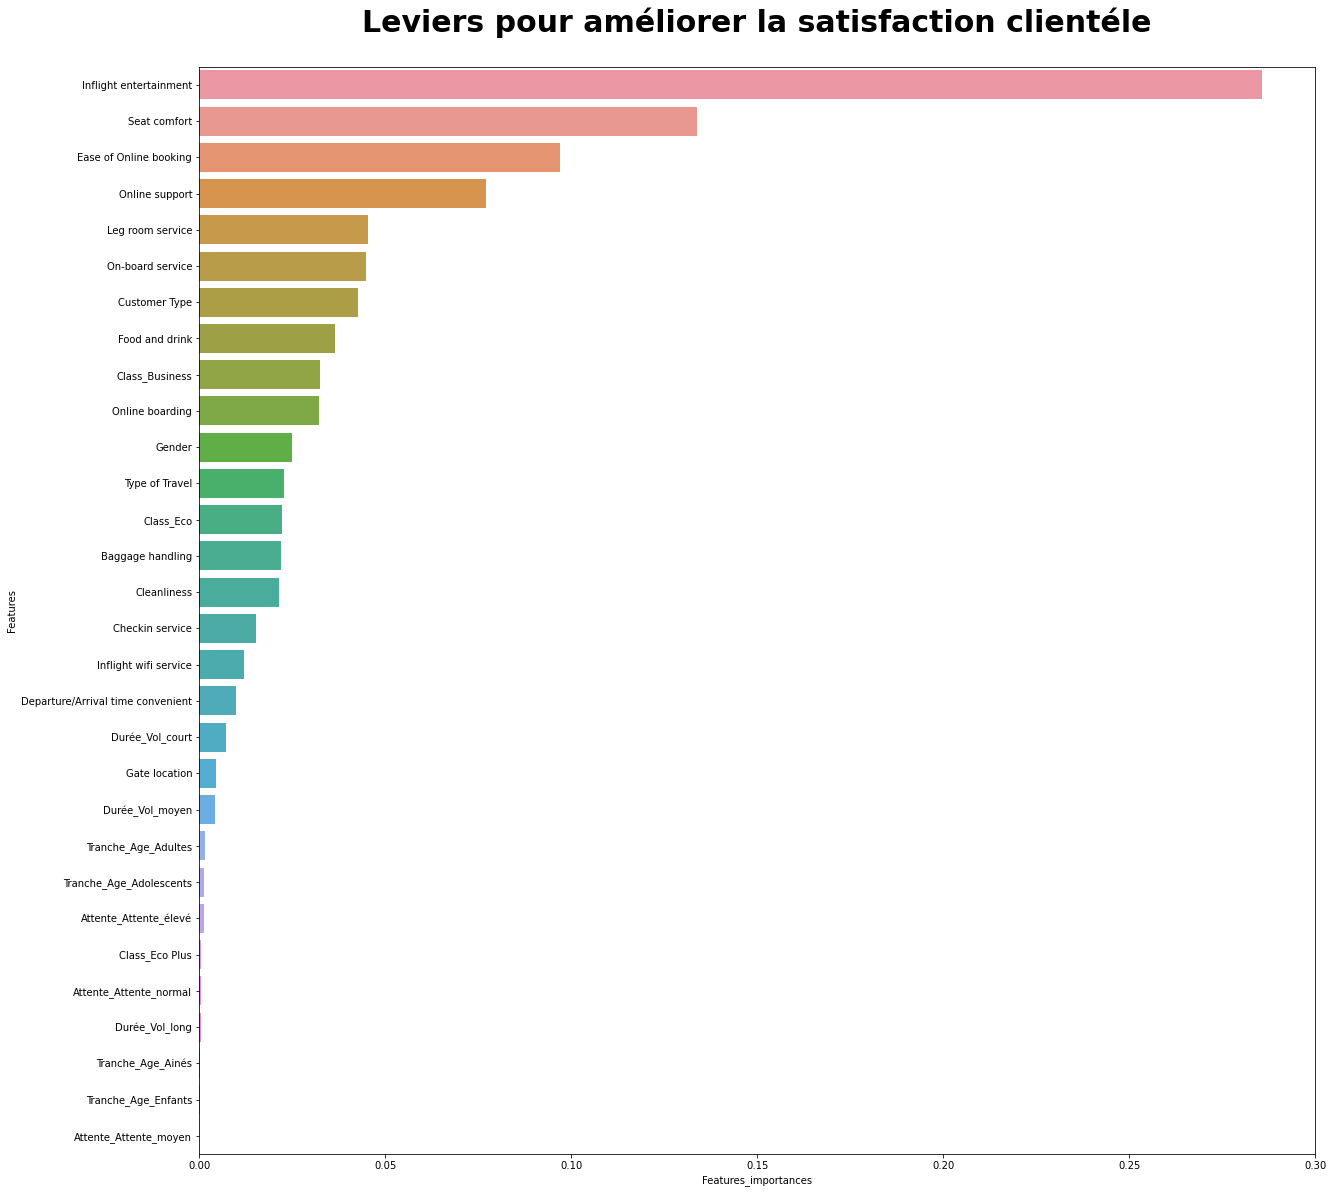

In [604]:
plt.figure(figsize=(20,20))
plt.title('Leviers pour améliorer la satisfaction clientéle',fontsize = 30, pad = 35, fontweight = 'bold')
sns.barplot(y='Features',x='Features_importances',data=df4.sort_values('Features_importances',ascending=False))
plt.show()